<a href="https://colab.research.google.com/github/argatf05/ApartmentPricing/blob/main/Predicting%20Daegu%20Apartment%20Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install catboost scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.2 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# data prep
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# model
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVR
from catboost import CatBoostRegressor


# evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import cross_val_score


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Business Problem Understanding

***Context***

A business is selling apartments in Daegu, a city in South Korea. As one of the urban areas in the nation, the demand for housing is high. At the same time, the city has limited residential land, making apartments one of the solutions. This makes analyzing apartment prices, influenced by various internal and external factors, a topic of great interest.

Apartment units are typically offered by individual owners or companies, who list them on platforms and set their own prices. However, adjusting these prices to match market conditions can be challenging. Overpricing may lead to difficulty in securing buyers, while underpricing can result in reduced profits for the seller.

Target: Sale Price



***Problem Statement***

Management is searching for the best way to predict sale prices, as this is essential for maximizing their profit. If they overprice the apartments, they risk losing customers, while underpricing could reduce their profit potential.

Currently, management has a method to predict apartment sale prices, but it is considered too simplistic for handling large datasets. They have been predicting apartment prices using rule-based model based on the median for each hallway type (terraced, mixed, and corridor). The median prices are 275,840 won for terraced, 155,799 won for mixed, and 87,968 won for corridor apartments.

Therefore, the problem statements are as follows:

1. What factors influence apartment pricing in Daegu?
2. What is the best model for predicting apartment prices, and how does this model forecast pricing in Daegu?
3. How can the business benefit from the model?



***Analytic Approach***

Management plan to build a best model to predict apartment pricing in Daegu. They plan to use the Machine Learning algorithm. Machine learning operates using models that are driven by algorithms, which can be fully reliant on data. Unlike rule-based algorithms, machine learning is highly scalable with increasing amounts of data. As the algorithm is exposed to more data, it improves its ability to identify key features, leading to enhanced performance (Source:socure.com).

Therefore, I will assist management in developing the best model for predicting apartment prices using a machine learning algorithm. Since this involves predicting apartment prices, it will be approached as a regression problem.


***Metric Evaluation***

The model will be evaluated using Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared. This project will primarily focus on RMSE, as apartment prices vary widely, ranging from lower-end to higher-end units. These price differences are crucial in predicting pricing accurately. RMSE is preferred because it places greater emphasis on larger errors by squaring them before averaging, making it more sensitive to outliers. In this project, large deviations in predicted prices could have significant financial consequences.




# Data Understanding

In [4]:
df = pd.read_csv('data_daegu_apartment.csv')
df

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
0,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1387,346017
1,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,5.0,1.0,0.0,1986,4,914,150442
2,mixed,15min~20min,Chil-sung-market,1.0,7.0,3.0,56.0,1997,5,558,61946
3,mixed,5min~10min,Bangoge,5.0,5.0,4.0,798.0,2005,7,914,165486
4,terraced,0-5min,Sin-nam,0.0,1.0,2.0,536.0,2006,5,1743,311504
...,...,...,...,...,...,...,...,...,...,...,...
4118,terraced,0-5min,Sin-nam,0.0,3.0,2.0,475.0,2008,8,914,323008
4119,mixed,15min~20min,Myung-duk,5.0,6.0,5.0,536.0,1993,4,1451,242477
4120,mixed,15min~20min,Myung-duk,5.0,6.0,5.0,536.0,1993,4,1761,168141
4121,corridor,5min~10min,Daegu,2.0,5.0,0.0,76.0,1985,3,676,73451


## Variables Description

| Variable | Description |
|---- | ---- |
| HallwayType | Type of Apartment (terraced, mixed, and corridor)|
| TimeToSubway | Time needed to the nearest subway station (in range of: 0-5 min; 5-10 min; 10-15 min; 15-20 min; and no_bus_stop_nearby)|
| SubwayStation | The name of the nearest subway station, there are 7 nearest subway and 1 no subway nearby|
| N_FacilitiesNearBy(ETC) | The number of Electronic Tolls Collection facilities nearby (0, 1, 2, and 5) |
| N_FacilitiesNearBy(PublicOffice) | The number of public office facilities nearby (0, 1, 2, 3, 4, 5, 6, 7) |
| N_SchoolNearBy(University) | The number of universities nearby (0, 1, 2, 3, 4, 5) |
| N_Parkinglot(Basement) | The number of the parking lot (0, 18, 56, 76, 79, 108, 181, 184, 203, 218, 400, 475, 524, 536, 605, 798, 930, 1174, 1270, 1321)|
| YearBuilt | The year the apartment was built (1978, 1980, 1985, 1986, 1992, 1993, 1997, 2003, 2005, 2006, 2007, 2008, 2009, 2013, 2014, 2015)|
| N_FacilitiesInApt | Number of facilities in the apartment (1, 2, 3, 4, 5, 7, 8, 9, 10)|
| Size(sqf)| The apartment size (in square feet)|
| SalePrice| The apartment price (Won)|

In [5]:
# Number of unique values in HallwayType column
num_unique_values = df['HallwayType'].nunique()

# Unique values
unique_values = df['HallwayType'].unique()

# Print the results
print(f"Number of unique values: {num_unique_values}")
print("Unique values:")
print(unique_values)

Number of unique values: 3
Unique values:
['terraced' 'mixed' 'corridor']


In [6]:
# Number of unique values in TimeToSubway column
num_unique_values = df['TimeToSubway'].nunique()

# Unique values
unique_values = df['TimeToSubway'].unique()

# Print the results
print(f"Number of unique values: {num_unique_values}")
print("Unique values:")
print(unique_values)

Number of unique values: 5
Unique values:
['0-5min' '10min~15min' '15min~20min' '5min~10min' 'no_bus_stop_nearby']


There are values of 'no_bus_stop_nearby,' which should actually mean 'no_subway_nearby.' This should be addressed later in the Data Cleaning section.

In [7]:
# Number of unique values in SubwayStation column
num_unique_values = df['SubwayStation'].nunique()

# Unique values
unique_values = df['SubwayStation'].unique()

# Print the results
print(f"Number of unique values: {num_unique_values}")
print("Unique values:")
print(unique_values)

Number of unique values: 8
Unique values:
['Kyungbuk_uni_hospital' 'Chil-sung-market' 'Bangoge' 'Sin-nam'
 'Banwoldang' 'no_subway_nearby' 'Myung-duk' 'Daegu']


In [8]:
# Number of unique values in N_FacilitiesNearBy(ETC) column
num_unique_values = df['N_FacilitiesNearBy(ETC)'].nunique()

# Unique values
unique_values = df['N_FacilitiesNearBy(ETC)'].unique()

# Print the results
print(f"Number of unique values: {num_unique_values}")
print("Unique values:")
print(unique_values)

Number of unique values: 4
Unique values:
[0. 1. 5. 2.]


In [9]:
# Number of unique values in N_FacilitiesNearBy(PublicOffice) column
num_unique_values = df['N_FacilitiesNearBy(PublicOffice)'].nunique()

# Unique values
unique_values = df['N_FacilitiesNearBy(PublicOffice)'].unique()

# Print the results
print(f"Number of unique values: {num_unique_values}")
print("Unique values:")
print(unique_values)

Number of unique values: 8
Unique values:
[3. 5. 7. 1. 4. 2. 6. 0.]


In [10]:
# Number of unique values in N_SchoolNearBy(University) column
num_unique_values = df['N_SchoolNearBy(University)'].nunique()

# Unique values
unique_values = df['N_SchoolNearBy(University)'].unique()

# Print the results
print(f"Number of unique values: {num_unique_values}")
print("Unique values:")
print(unique_values)

Number of unique values: 6
Unique values:
[2. 1. 3. 4. 5. 0.]


In [11]:
# Number of unique values in N_Parkinglot(Basement) column
num_unique_values = df['N_Parkinglot(Basement)'].nunique()

# Unique values
unique_values = df['N_Parkinglot(Basement)'].unique()

# Print the results
print(f"Number of unique values: {num_unique_values}")
print("Unique values:")
print(unique_values)

Number of unique values: 20
Unique values:
[1270.    0.   56.  798.  536.  605.  203.  108. 1174.  930.  475.  184.
  400.  218. 1321.  524.   76.   79.  181.   18.]


In [12]:
# Number of unique values in YearBuilt column
num_unique_values = df['YearBuilt'].nunique()

# Unique values
unique_values = df['YearBuilt'].unique()

# Print the results
print(f"Number of unique values: {num_unique_values}")
print("Unique values:")
print(unique_values)

Number of unique values: 16
Unique values:
[2007 1986 1997 2005 2006 2009 2014 1993 2013 2008 2015 1978 1985 1992
 2003 1980]


In [13]:
# Number of unique values in N_FacilitiesInApt column
num_unique_values = df['N_FacilitiesInApt'].nunique()

# Unique values
unique_values = df['N_FacilitiesInApt'].unique()

# Print the results
print(f"Number of unique values: {num_unique_values}")
print("Unique values:")
print(unique_values)

Number of unique values: 9
Unique values:
[10  4  5  7  2  9  8  1  3]


## Missing Values

In [14]:
#Missing values (NaN) in each variable
missing = pd.DataFrame({'Total':df.isnull().sum().sort_values(ascending = False)})
missing

total_data_row = len(df)
missing['Percentage %'] = round((missing['Total']/total_data_row)*100,2)
missing

,Total,Percentage %
HallwayType,0,0.0
TimeToSubway,0,0.0
SubwayStation,0,0.0
N_FacilitiesNearBy(ETC),0,0.0
N_FacilitiesNearBy(PublicOffice),0,0.0
N_SchoolNearBy(University),0,0.0
N_Parkinglot(Basement),0,0.0
YearBuilt,0,0.0
N_FacilitiesInApt,0,0.0
Size(sqf),0,0.0


<Axes: >

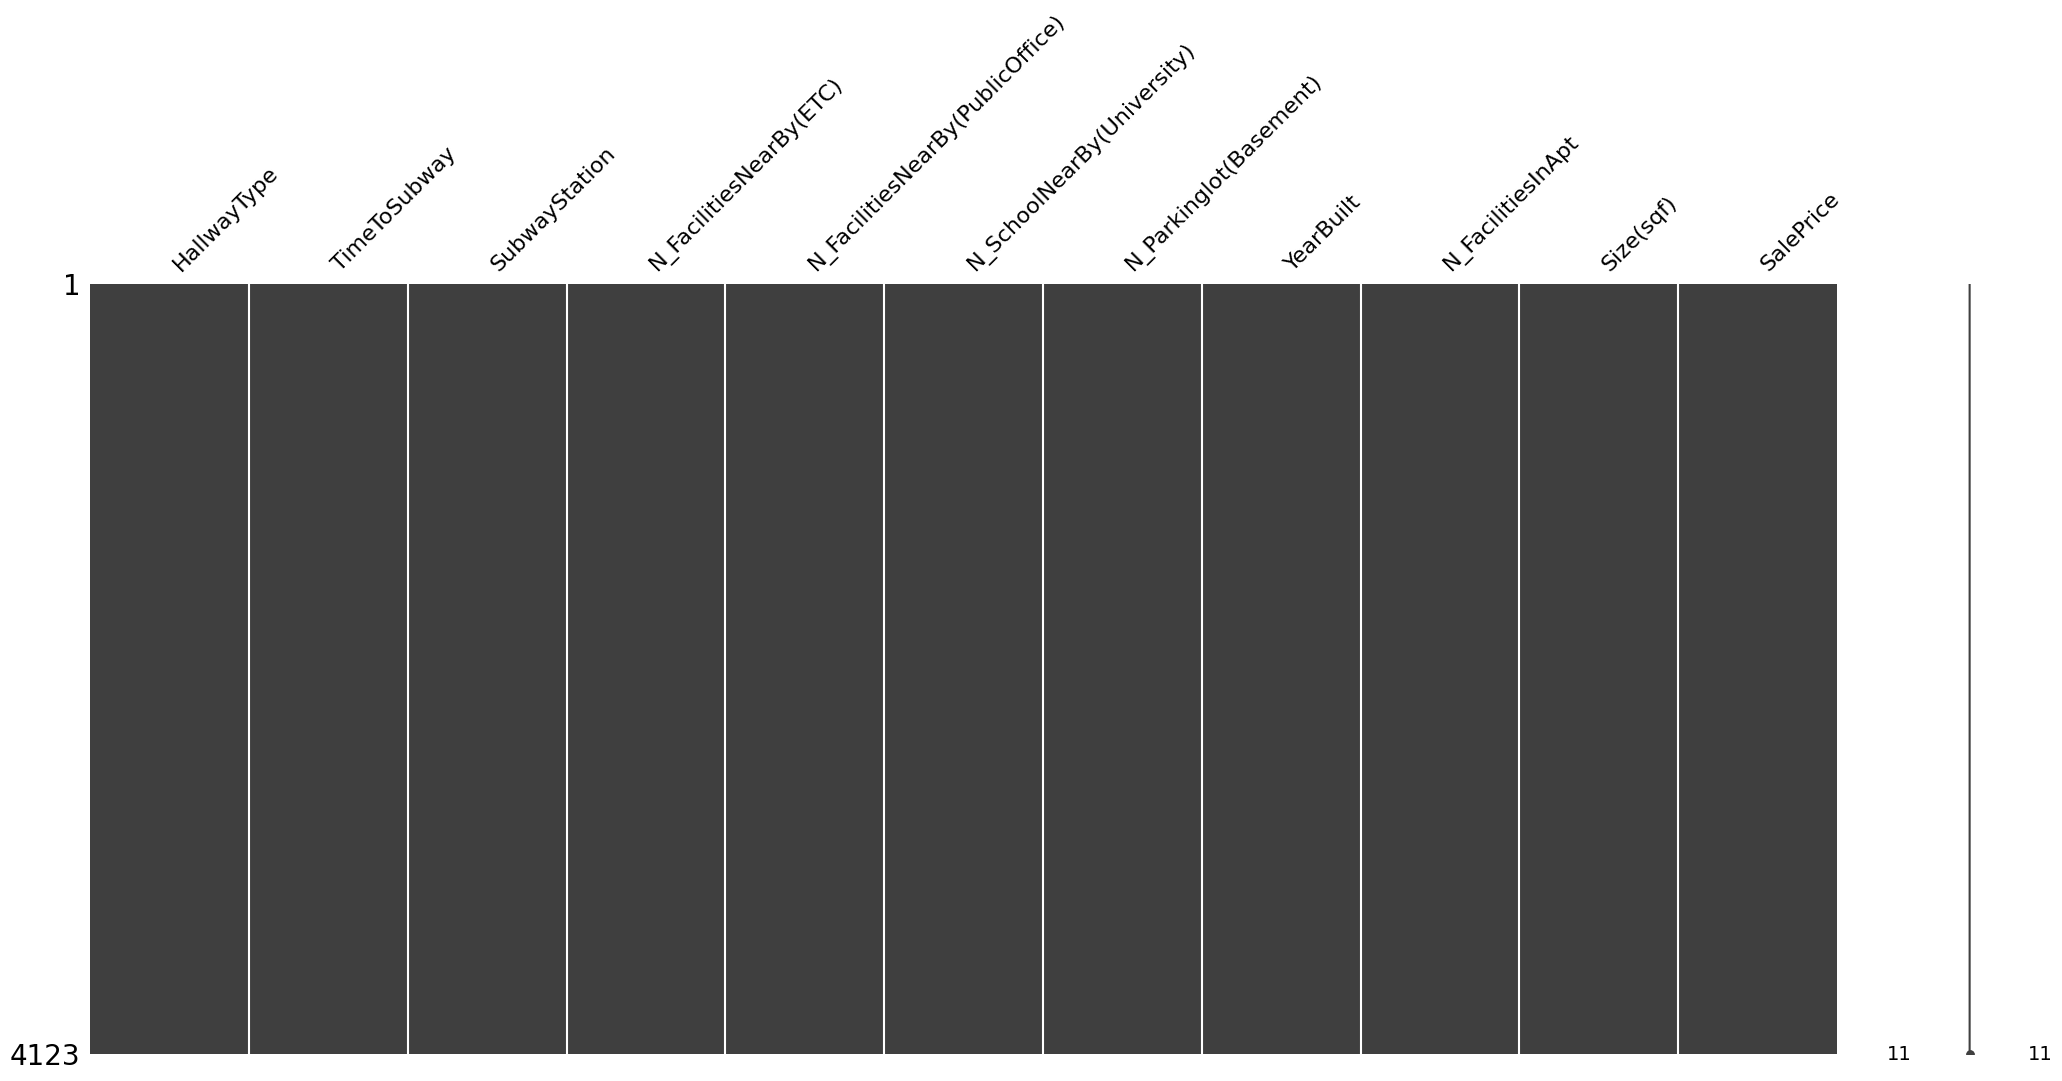

In [15]:
import missingno

# Missing values in visualization
missingno.matrix(df)

I found no missing values in the data; therefore, no further work is needed in the Data Cleaning section for handling missing values.

## Duplicated Data

In [16]:
# Get duplicated rows
duplicated_rows = df[df.duplicated() | df.duplicated(keep=False)]

# Sort by all columns
sorted_duplicated_rows = duplicated_rows.sort_values(by=list(df.columns))

# Print the sorted duplicated rows
sorted_duplicated_rows

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
385,corridor,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,0.0,1978,3,903,126548
1428,corridor,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,0.0,1978,3,903,126548
628,corridor,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,0.0,1978,3,903,128318
3810,corridor,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,0.0,1978,3,903,128318
258,corridor,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,0.0,1978,3,903,212389
...,...,...,...,...,...,...,...,...,...,...,...
1946,terraced,no_bus_stop_nearby,no_subway_nearby,2.0,2.0,1.0,203.0,2009,5,1160,265442
2136,terraced,no_bus_stop_nearby,no_subway_nearby,2.0,2.0,1.0,203.0,2009,5,1160,265442
3511,terraced,no_bus_stop_nearby,no_subway_nearby,2.0,2.0,1.0,203.0,2009,5,1160,265442
3600,terraced,no_bus_stop_nearby,no_subway_nearby,2.0,2.0,1.0,203.0,2009,5,1160,265442


I found that there are duplicated rows; however, in the context of this apartment data, the duplicate rows are considered normal since they might represent the same type of unit, hence they have relatively the same variables. Moreover, the data does not contain any unique code (like an ID) to distinguish each row.

Therefore, the duplicated rows will not be deleted.

## Numeric Variables

### Statistical Descriptive

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   HallwayType                       4123 non-null   object 
 1   TimeToSubway                      4123 non-null   object 
 2   SubwayStation                     4123 non-null   object 
 3   N_FacilitiesNearBy(ETC)           4123 non-null   float64
 4   N_FacilitiesNearBy(PublicOffice)  4123 non-null   float64
 5   N_SchoolNearBy(University)        4123 non-null   float64
 6   N_Parkinglot(Basement)            4123 non-null   float64
 7   YearBuilt                         4123 non-null   int64  
 8   N_FacilitiesInApt                 4123 non-null   int64  
 9   Size(sqf)                         4123 non-null   int64  
 10  SalePrice                         4123 non-null   int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 354.4+ KB


It was found that the data types for HallwayType, TimeToSubway, and SubwayStation are objects, whereas they should be categorical (please see the Variables Description section). Therefore, these variables should eventually be encoded using One-Hot Encoding in the Data Preparation section.

In [18]:
df.describe()

,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
count,4123.000000,4123.000000,4123.000000,4123.000000,4123.000000,4123.000000,4123.000000,4123.000000
mean,1.930876,4.135338,2.746301,568.979141,2002.999757,5.817851,954.630851,221767.926995
std,2.198832,1.802640,1.496610,410.372742,8.905768,2.340507,383.805648,106739.839945
min,0.000000,0.000000,0.000000,0.000000,1978.000000,1.000000,135.000000,32743.000000
25%,0.000000,3.000000,2.000000,184.000000,1993.000000,4.000000,644.000000,144752.000000
50%,1.000000,5.000000,2.000000,536.000000,2006.000000,5.000000,910.000000,209734.000000
75%,5.000000,5.000000,4.000000,798.000000,2008.000000,7.000000,1149.000000,291150.000000
max,5.000000,7.000000,5.000000,1321.000000,2015.000000,10.000000,2337.000000,585840.000000




Total sample is 4,123
*   Median of Number of Facilities Nearby (Electronic Toll Collection) is 1
*   Median of Number of Facilities Nearby (Public Office) is 5
*   Median of Number of School Nearby (University) is 2
*   Median of Number of Parking Lot (Basement) is 536
*   Median of Year Built (Basement) is 2006
*   Median of Facilities in Apartment is 5
*   Median of Size (sqf) is 910
*   Median of Sale Price is 209,734



### Data Distribution

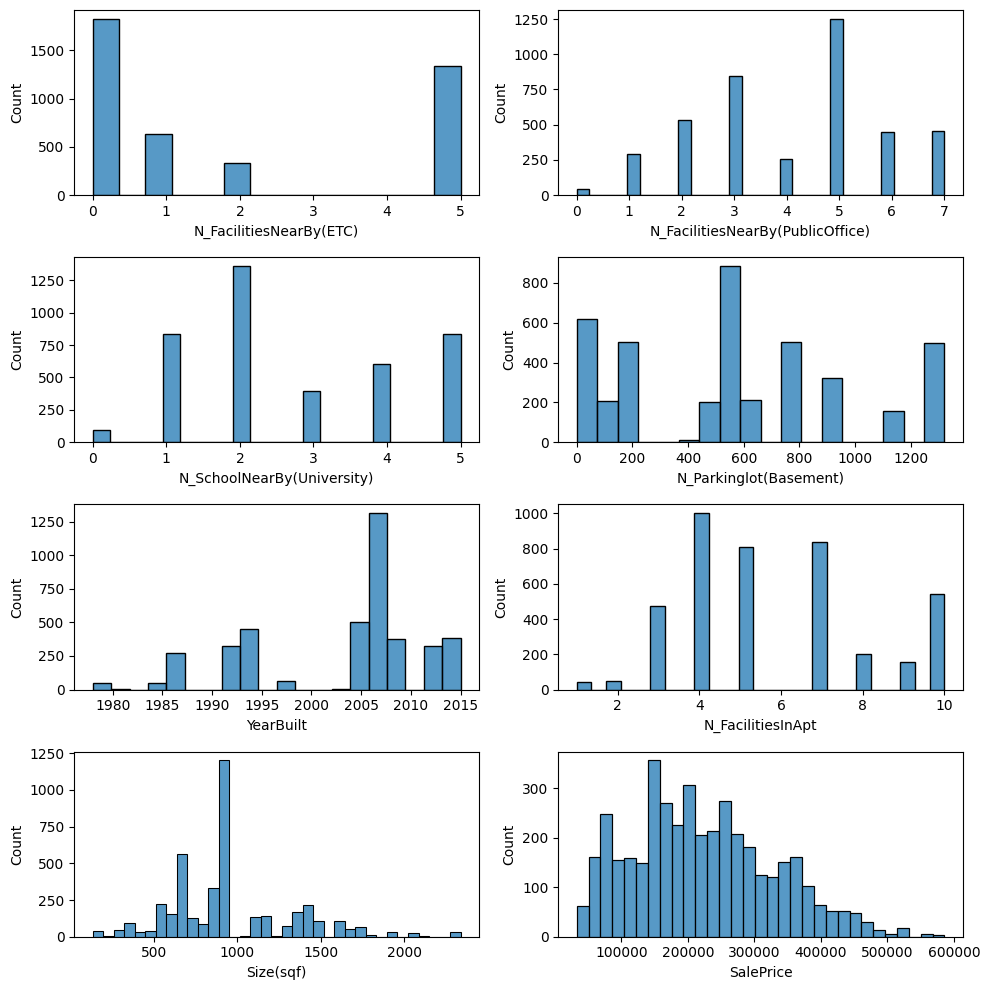

In [19]:
numeric = df.select_dtypes(include = 'number')
plt.figure(figsize = (10,10))

position = 1 # Initiating position starting from 1
for each_column in numeric.columns:
    plt.subplot(4,2,position)
    sns.histplot(df[each_column])
    position = position + 1
    plt.tight_layout()

It is shown that none of the variables are normally distributed. The target variable, SalePrice, is right-skewed.

### Outliers

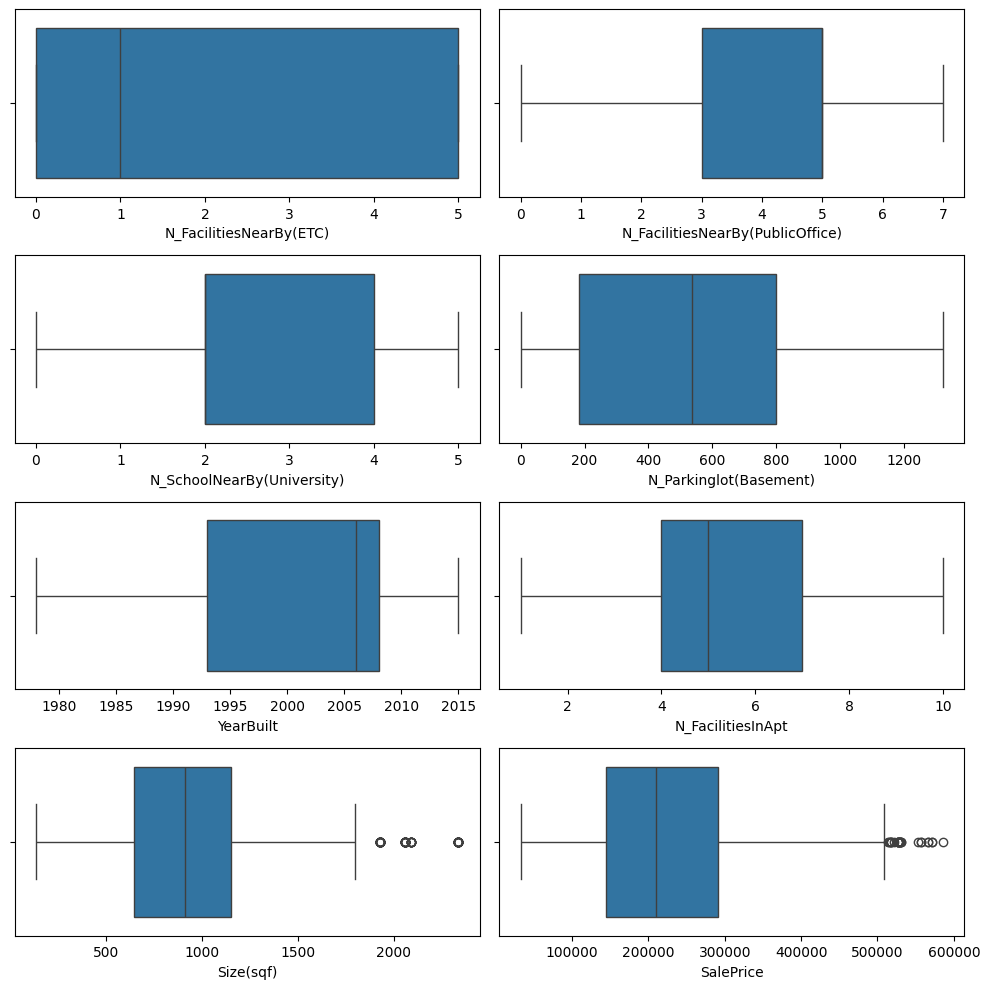

In [20]:
numeric = df.select_dtypes(include = 'number')
plt.figure(figsize = (10,10))

position = 1 # Initiating position starting from 1
for each_column in numeric.columns:
    plt.subplot(4,2,position)
    sns.boxplot(x = df[each_column])
    position = position + 1
    plt.tight_layout()

Outliers were found in several variables, namely Size and SalePrice. Therefore, it is considered appropriate to experiment with excluding the outliers from the model. This experiment will be conducted later in the Modelling section. The outliers may represent luxury apartments, which have significantly higher prices.

### Correlations

<Axes: >

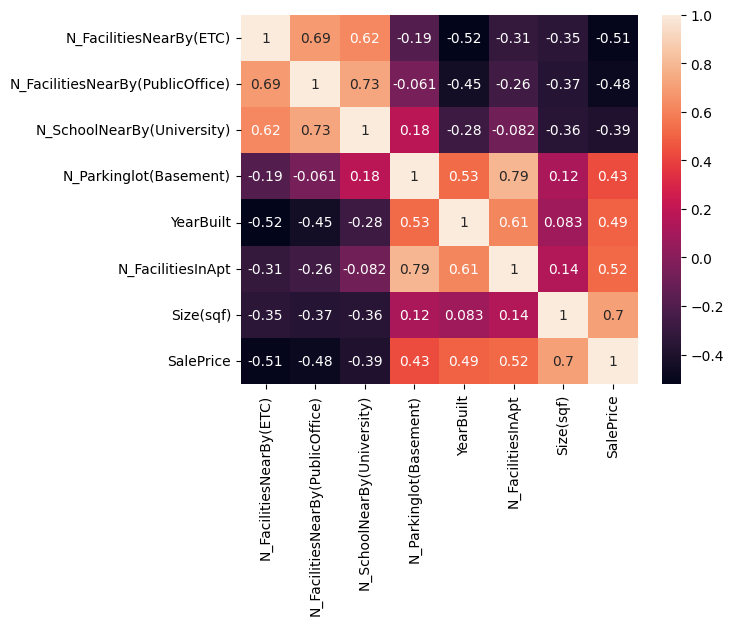

In [21]:
sns.heatmap(numeric.corr(method = 'spearman'), annot = True)

It was found that the target variable, SalePrice, is highly correlated with Size (0.7). Therefore, Size is one of the features that will be retained. Meanwhile, N_FacilitiesNearBy(ETC), N_FacilitiesNearBy(PublicOffice), N_SchoolNearBy(University), N_FacilitiesInApt, N_ParkingLot(Basement), and YearBuilt exhibit multicollinearity and are considered for removal. These variables will be removed during Experiment 3: Feature Engineering, and I will evaluate whether their removal improves the model's performance.

### Multicollinearity using VIF

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(x):
    vif = pd.DataFrame()
    vif['variables'] = x.columns
    # calculate vif for each column
    vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    return vif

In [23]:
calc_vif(numeric.drop(columns = 'SalePrice')).sort_values(by = 'VIF', ascending = False)

,variables,VIF
4,YearBuilt,34.327180
5,N_FacilitiesInApt,27.840728
2,N_SchoolNearBy(University),18.284972
1,N_FacilitiesNearBy(PublicOffice),15.342707
3,N_Parkinglot(Basement),12.254853
6,Size(sqf),8.567090
0,N_FacilitiesNearBy(ETC),5.474361


It was found that YearBuilt, N_FacilitiesInApt, N_SchoolNearBy(University), N_FacilitiesNearBy(PublicOffice), and N_ParkingLot(Basement) have VIF values above 10, indicating high multicollinearity. Therefore, I will conduct an experiment where these variables are retained and removed, allowing us to compare the model's performance with and without the variables (See: Experiment 3: Feature Engineering).

## Categorical Variables

### Statistical Descriptive

In [24]:
df.describe(include = 'object')

,HallwayType,TimeToSubway,SubwayStation
count,4123,4123,4123
unique,3,5,8
top,terraced,0-5min,Kyungbuk_uni_hospital
freq,2528,1953,1152


### Unique Values

In [25]:
categorical = df.select_dtypes(include = 'object')
categorical.nunique()


,0
HallwayType,3
TimeToSubway,5
SubwayStation,8


### Value Counts

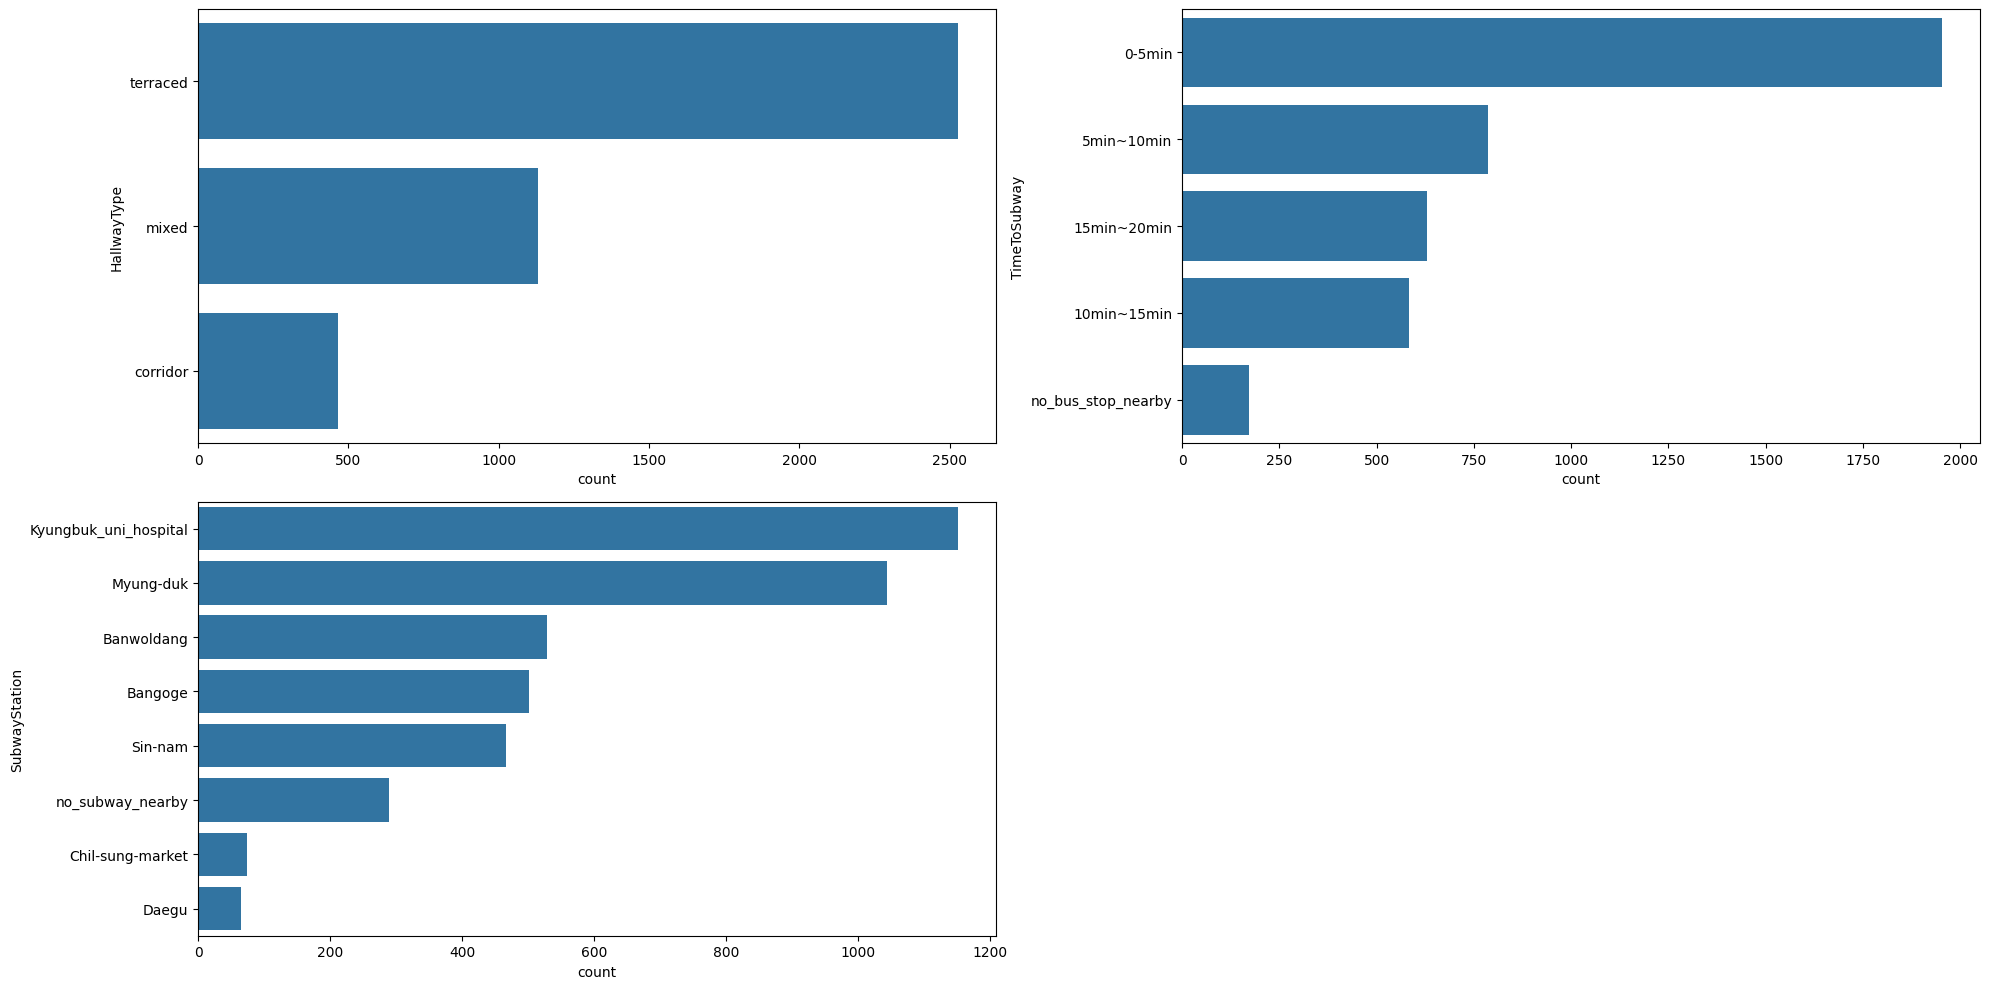

In [26]:
plt.figure(figsize = (20,10))

position = 1 # Initiating position starting from 1
for each_column in categorical.columns:
    plt.subplot(2,2,position)
    sns.barplot(df[each_column].value_counts(), orient = 'h')
    position = position + 1
    plt.tight_layout()

Based on the Statistical Descriptive, Unique Values, and Value Counts sections:

HallwayType has 3 unique values, with 'terraced' being the most common type in the data.
TimeToSubway has 5 unique values, with the '0-5 min' range being the most frequent in the data.
SubwayStation has 8 unique values, with Kyungbuk_uni_hospital being the most common in the data. These findings will be explored further in the Exploratory Data Analysis (EDA) section.

# Data Cleaning

In [27]:
# Replacing no_bus_stop_nearby with no_subway_nearby due to a typo

df['TimeToSubway'].replace('no_bus_stop_nearby', 'no_subway_nearby', inplace=True)

In [28]:
df

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
0,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1387,346017
1,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,5.0,1.0,0.0,1986,4,914,150442
2,mixed,15min~20min,Chil-sung-market,1.0,7.0,3.0,56.0,1997,5,558,61946
3,mixed,5min~10min,Bangoge,5.0,5.0,4.0,798.0,2005,7,914,165486
4,terraced,0-5min,Sin-nam,0.0,1.0,2.0,536.0,2006,5,1743,311504
...,...,...,...,...,...,...,...,...,...,...,...
4118,terraced,0-5min,Sin-nam,0.0,3.0,2.0,475.0,2008,8,914,323008
4119,mixed,15min~20min,Myung-duk,5.0,6.0,5.0,536.0,1993,4,1451,242477
4120,mixed,15min~20min,Myung-duk,5.0,6.0,5.0,536.0,1993,4,1761,168141
4121,corridor,5min~10min,Daegu,2.0,5.0,0.0,76.0,1985,3,676,73451


# Exploratory Data Analysis (EDA)

### Pairplot

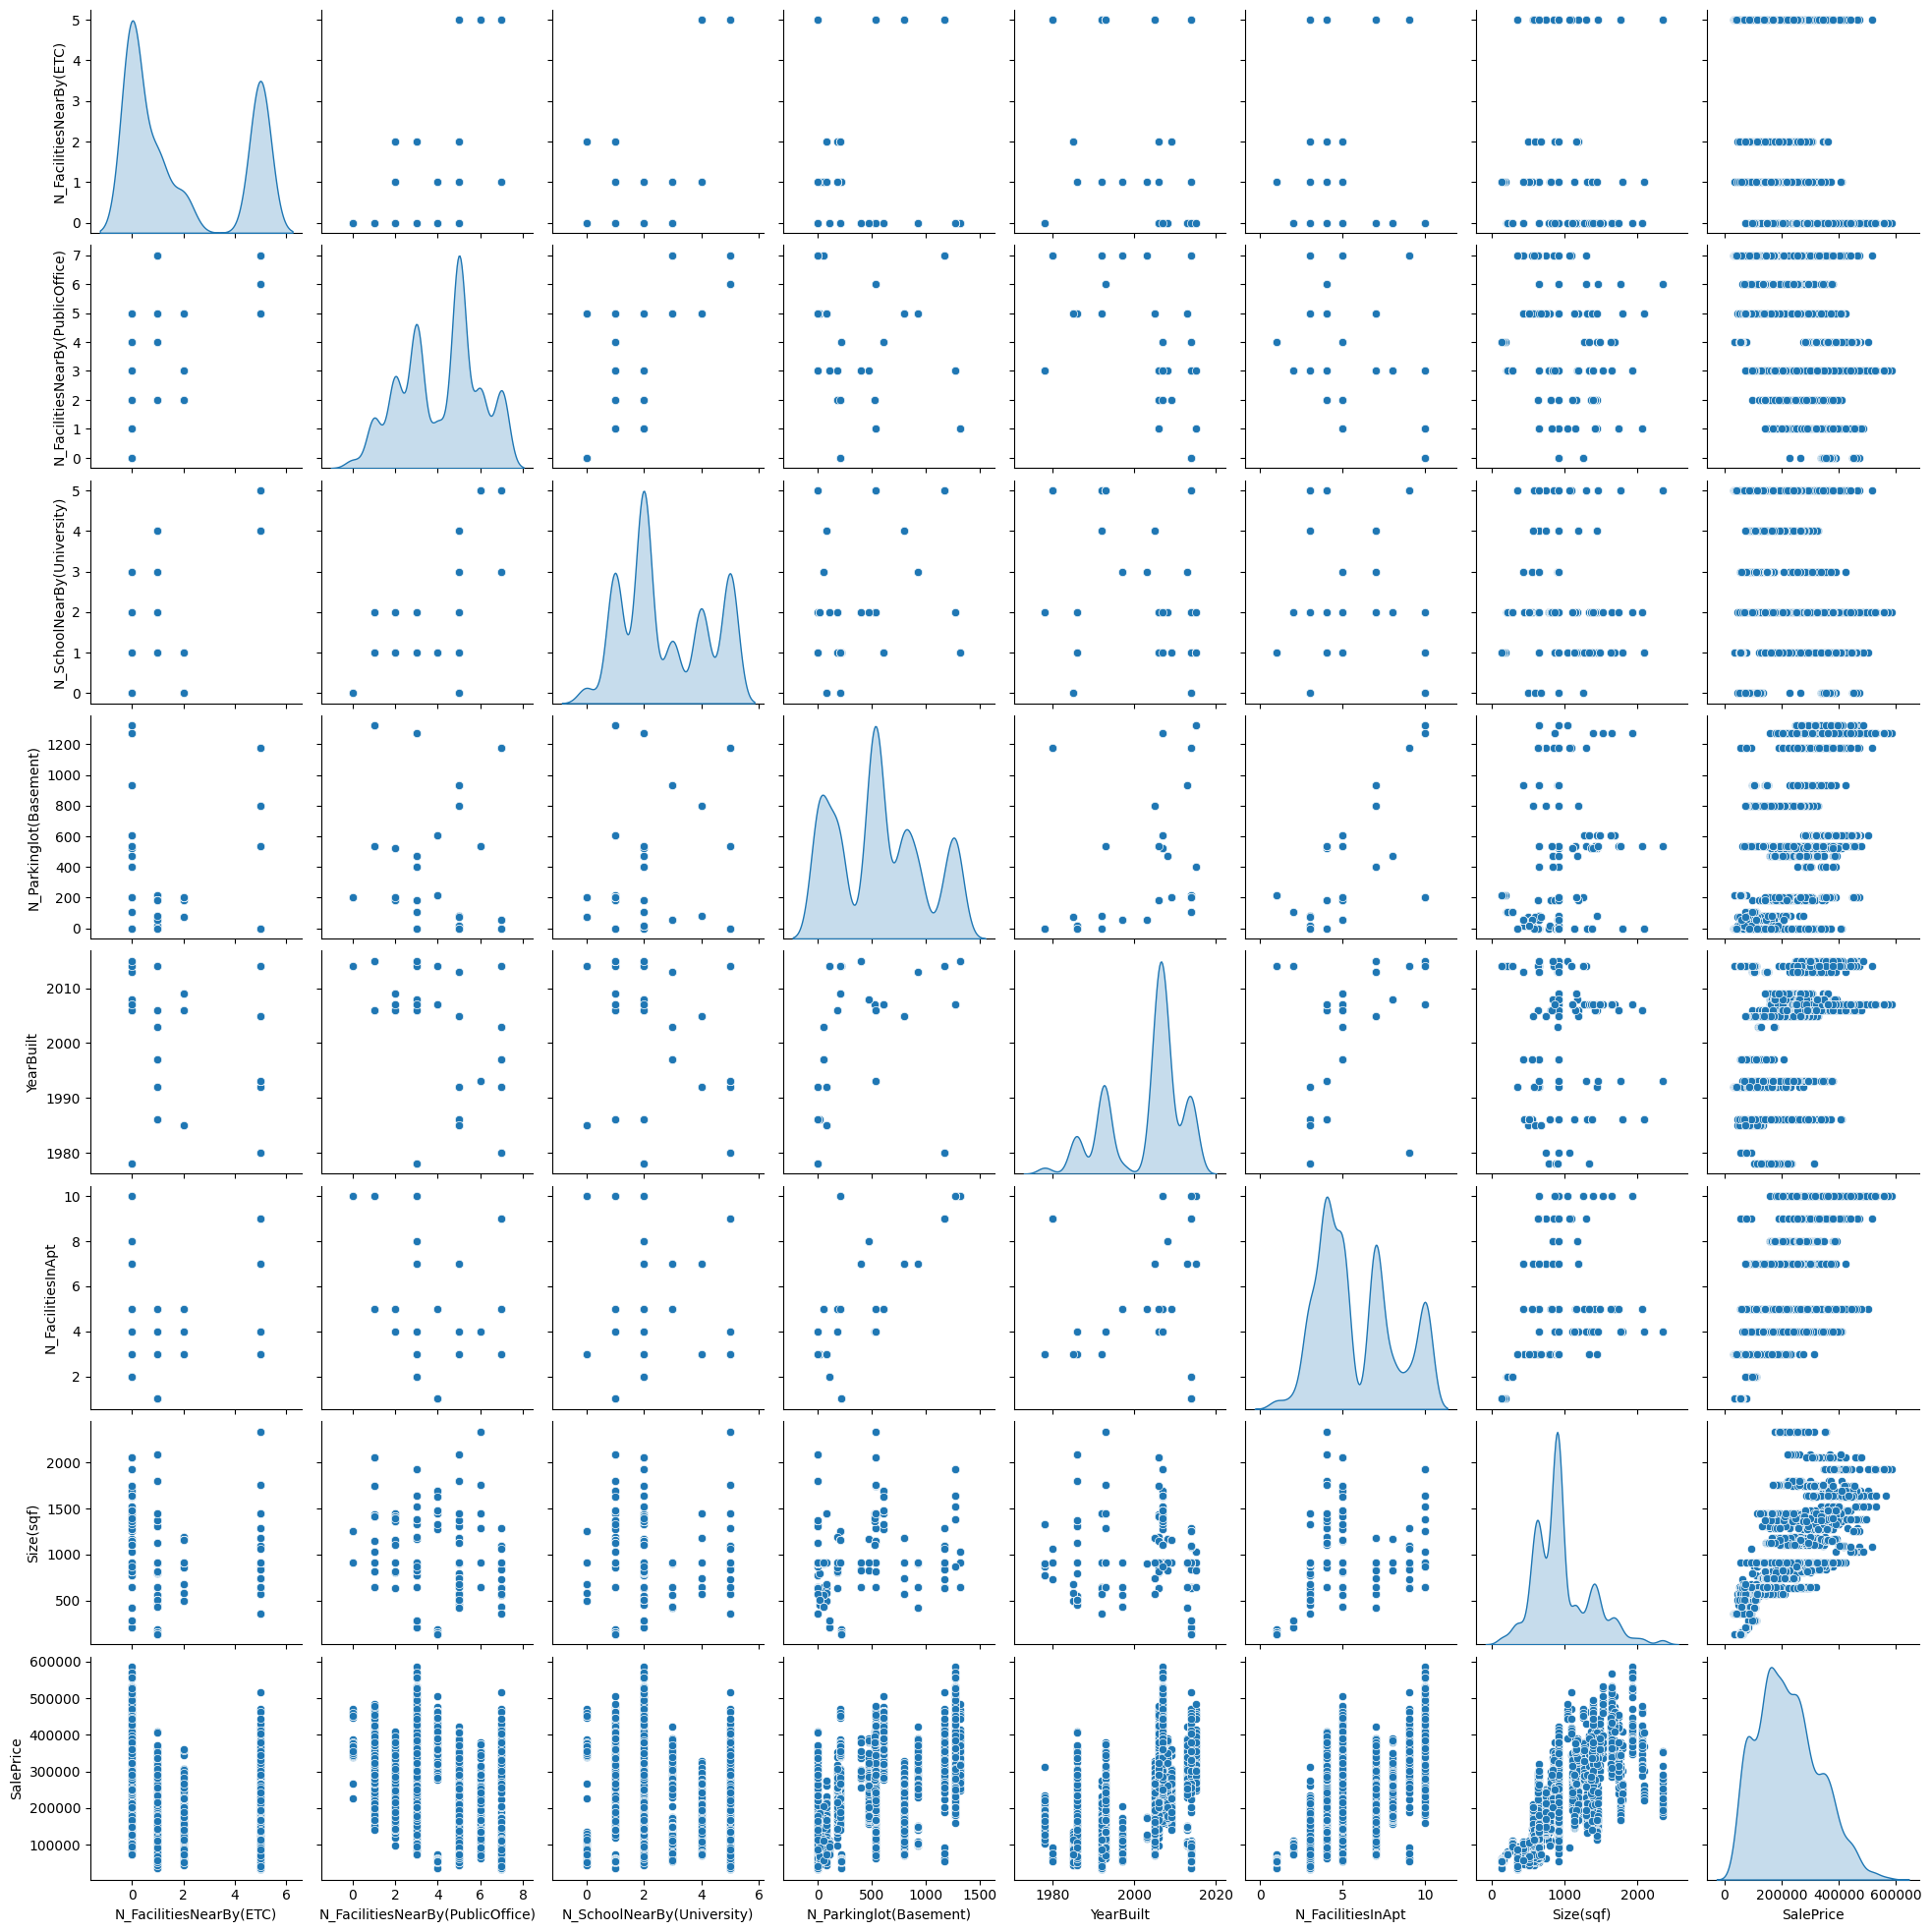

In [29]:
# Observe collinearity between numerical features using pairplot
sns.pairplot(df, diag_kind = 'kde')

As we can see, the relationship between the features and SalePrice (the target variable) is not linear; therefore, we should not rely solely on linear regression in the Modelling section.

### Grouping Visualization of SalePrice based on Categorical Variables

<ipython-input-30-2cc1c634739e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x=col, y="SalePrice", kind="bar", dodge=False, height=4, aspect=3, data=df, palette="Set1")


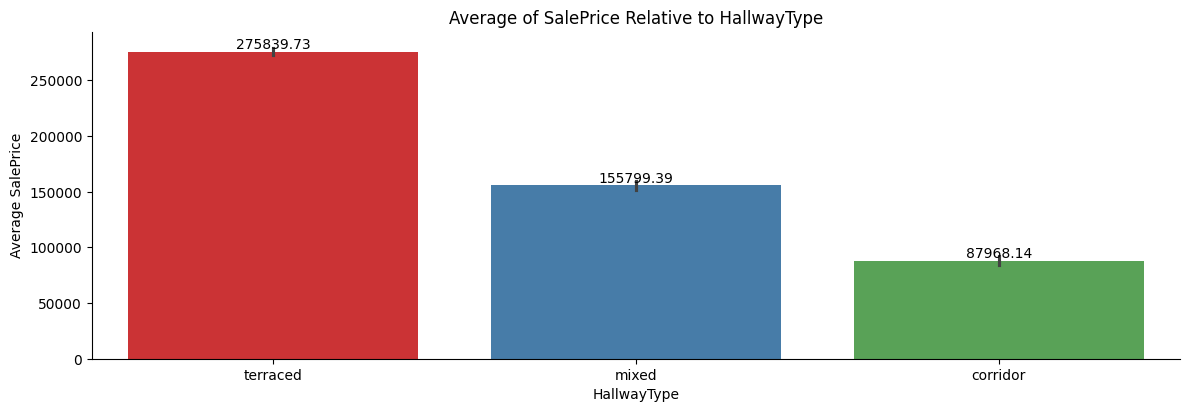

<ipython-input-30-2cc1c634739e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x=col, y="SalePrice", kind="bar", dodge=False, height=4, aspect=3, data=df, palette="Set1")


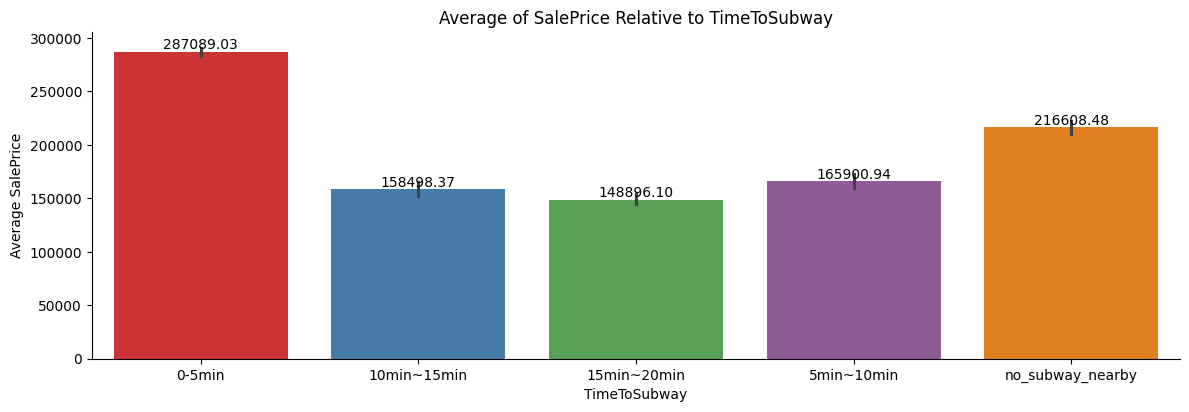

<ipython-input-30-2cc1c634739e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x=col, y="SalePrice", kind="bar", dodge=False, height=4, aspect=3, data=df, palette="Set1")


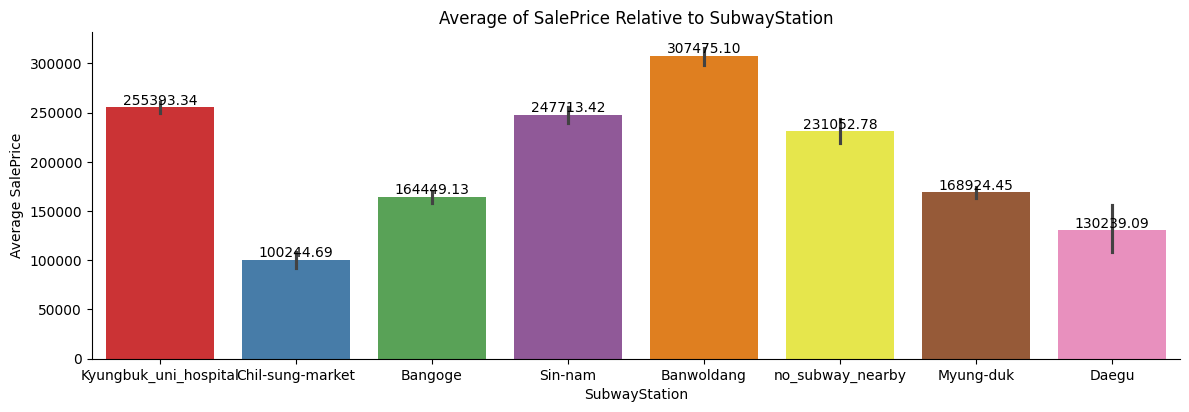

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

cat_features = df.select_dtypes(include='object').columns.to_list()

for col in cat_features:
    # Create the bar plot
    g = sns.catplot(x=col, y="SalePrice", kind="bar", dodge=False, height=4, aspect=3, data=df, palette="Set1")

    # Get the axes of the plot
    ax = g.axes[0, 0]

    # Add labels on each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

    plt.title("Average of SalePrice Relative to {}".format(col))
    plt.xlabel(col)
    plt.ylabel("Average SalePrice")
    plt.show()


As we can see:

1. The terraced hallway type has the highest average SalePrice
2. A travel time of 0-5 minutes to the subway has the highest average SalePrice
3. Apartments near Banwoldang subway station have the highest average SalePrice

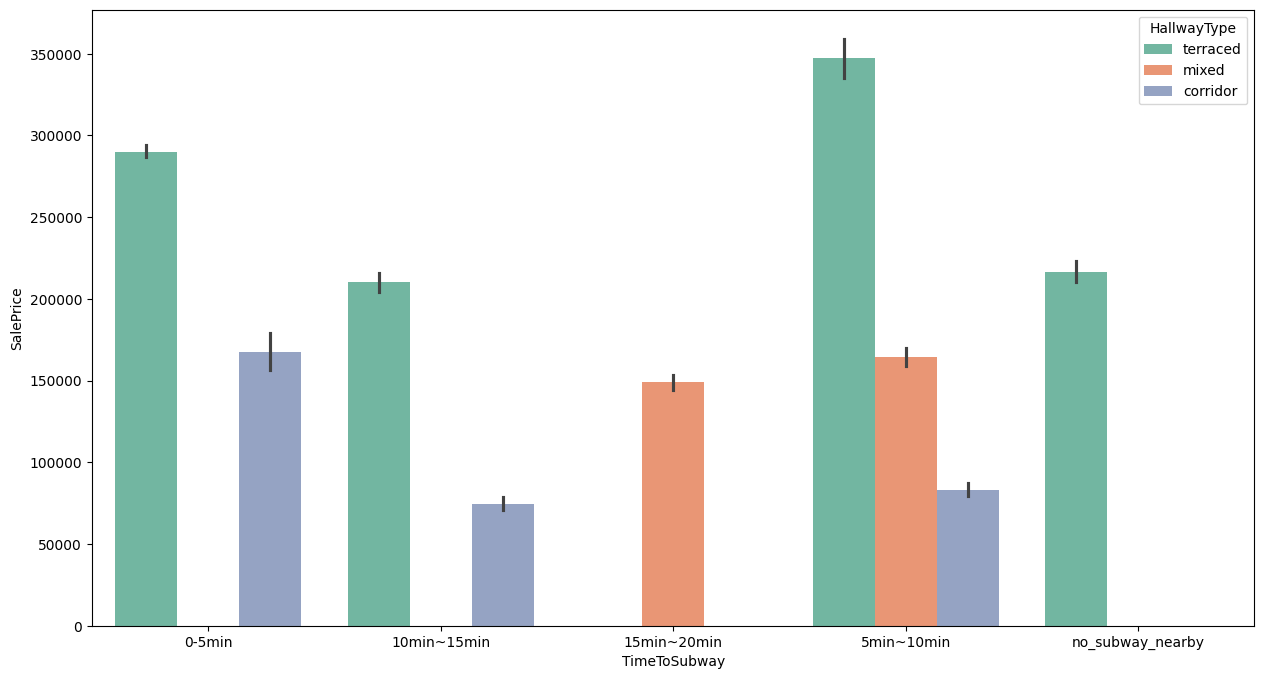

In [31]:
f, ax = plt.subplots(1, 1, figsize=(15, 8))
ax = sns.barplot(x='TimeToSubway', y='SalePrice', hue='HallwayType', data=df, palette='Set2')

I found earlier that the terraced hallway type and a travel time of 0-5 minutes to the subway had the highest average sale price. However, after further investigation based on the graph above, I discovered that the highest average sale price actually came from the terraced hallway type and a travel time of 5-10 minutes to the subway.

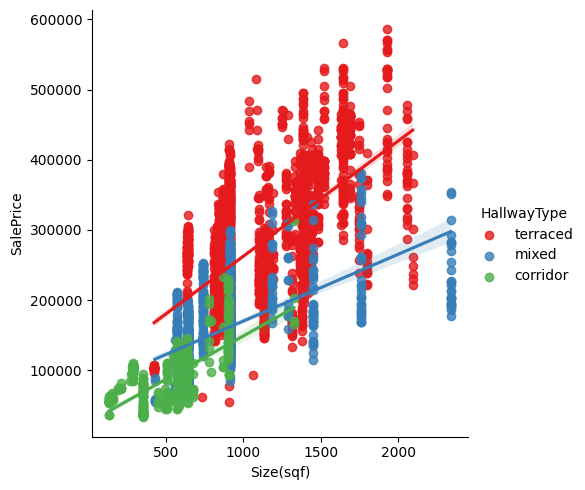

In [32]:
ax = sns.lmplot(x = 'Size(sqf)', y = 'SalePrice', data=df, hue='HallwayType', palette='Set1')

As we can see from the graph above, SalePrice and Size (sqf) have a positive relationship, where a larger size corresponds to a higher SalePrice. Furthermore, the highest average SalePrice comes from the terraced hallway type, followed by mixed, and then corridor.

In [33]:
# Total SalePrice for 'terraced' HallwayType
total_terraced = df[(df['HallwayType'] == 'terraced')]['SalePrice'].sum()

# Total SalePrice for 'mixed' HallwayType
total_mixed = df[(df['HallwayType'] == 'mixed')]['SalePrice'].sum()

# Total SalePrice for 'corridor' HallwayType
total_corridor = df[(df['HallwayType'] == 'corridor')]['SalePrice'].sum()

data_hallwaytype = {
    'HallwayType': ['terraced', 'mixed', 'corridor'],
    'TotalSalePrice': [total_terraced, total_mixed, total_corridor]
}

df_hallwaytype = pd.DataFrame(data_hallwaytype)

# Sort the DataFrame in descending order by TotalSalePrice
df_hallwaytype.sort_values(by='TotalSalePrice', ascending=False)

,HallwayType,TotalSalePrice
0,terraced,697322835
1,mixed,176209112
2,corridor,40817216


Besides having the highest average SalePrice, we can confirm that the total SalePrice from the terraced hallway type is also the highest. This finding will be considered for inclusion in the modeling process to gain a more robust understanding for business decisions.

# Data Splitting

In [34]:
X = df.drop(columns = 'SalePrice')
y = df['SalePrice']

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [36]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3298, 10), (825, 10), (3298,), (825,))

# Data Preparation

In [37]:
transformer = ColumnTransformer([
    ('one hot', OneHotEncoder(drop = 'first'), ['HallwayType', 'TimeToSubway', 'SubwayStation']),
    ('scaler', MinMaxScaler(), ['N_FacilitiesNearBy(ETC)', 'N_FacilitiesNearBy(PublicOffice)', 'N_SchoolNearBy(University)','N_Parkinglot(Basement)', 'YearBuilt','N_FacilitiesInApt','Size(sqf)'])
], remainder = 'passthrough')
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('one hot', OneHotEncoder(drop='first'),
                                 ['HallwayType', 'TimeToSubway',
                                  'SubwayStation']),
                                ('scaler', MinMaxScaler(),
                                 ['N_FacilitiesNearBy(ETC)',
                                  'N_FacilitiesNearBy(PublicOffice)',
                                  'N_SchoolNearBy(University)',
                                  'N_Parkinglot(Basement)', 'YearBuilt',
                                  'N_FacilitiesInApt', 'Size(sqf)'])])

# Modelling

## Rule-Based Model (Non-Machine Learning)

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Step 1: Define the rule-based model
def rule_based_model(row):
    if row['HallwayType'] == 'terraced':
        return 275839.73
    elif row['HallwayType'] == 'mixed':
        return 155799.39
    elif row['HallwayType'] == 'corridor':
        return 87968.14
    else:
        return np.nan  # If there are any other categories, we return NaN

# Step 2: Apply the rule-based model to create predictions
y_test_rule_based = X_test.apply(rule_based_model, axis=1)

# Step 3: Calculate R², RMSE, and MAE between actual SalePrice and rule-based SalePrice
r2_rule_based = r2_score(y_test, y_test_rule_based)
mae_rule_based = mean_absolute_error(y_test, y_test_rule_based)
rmse_rule_based = np.sqrt(mean_squared_error(y_test, y_test_rule_based))

# Step 4: Print the results
print("Rule-Based Model Performance:")
print(f"R²: {r2_rule_based:.4f}")
print(f"MAE: {mae_rule_based:.4f}")
print(f"RMSE: {rmse_rule_based:.4f}")


Rule-Based Model Performance:
R²: 0.4544
MAE: 63444.6499
RMSE: 79598.1420


The rule-based model is set based on pricing median from each hallway types.

It is found that the RMSE for the rule based is 79,598, it will be compared to the best Machine Learning model to decide whether the Machine Learning model is better than the rule-based model set by the management.

Furthermore, the independent variable (HallwayType) from rule-based model only explained 45.44% of dependent variable (SalePrice), indicating that there might be other factors that explained the SalePrice.

## Experiment 1: Based Model

In [39]:
# Checking the dependent variable (SalePrice)
y

,SalePrice
0,346017
1,150442
2,61946
3,165486
4,311504
...,...
4118,323008
4119,242477
4120,168141
4121,73451


In [40]:
# Checking for scaling
X_train_unscaled = X_train
X_test_unscaled = X_test

In [41]:
X_train_unscaled

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf)
1412,mixed,15min~20min,Myung-duk,1.0,5.0,4.0,79.0,1992,3,644
2007,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,5.0,1.0,0.0,1986,4,1131
3053,terraced,0-5min,Banwoldang,0.0,4.0,1.0,605.0,2007,5,1629
311,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,5.0,1.0,0.0,1986,4,914
75,mixed,5min~10min,Bangoge,5.0,5.0,4.0,798.0,2005,7,1184
...,...,...,...,...,...,...,...,...,...,...
3046,terraced,0-5min,Kyungbuk_uni_hospital,0.0,5.0,3.0,930.0,2013,7,910
1725,terraced,0-5min,Sin-nam,0.0,3.0,2.0,475.0,2008,8,914
4079,terraced,0-5min,Sin-nam,0.0,1.0,2.0,536.0,2006,5,914
2254,mixed,15min~20min,Myung-duk,5.0,6.0,5.0,536.0,1993,4,644


In [42]:
# Scaling dataset
X_train=pd.DataFrame(transformer.fit_transform(X_train),columns=transformer.get_feature_names_out())
X_test=pd.DataFrame(transformer.transform(X_test),columns=transformer.get_feature_names_out())

In [43]:
# Checking for scaling
X_train.head()

,one hot__HallwayType_mixed,one hot__HallwayType_terraced,one hot__TimeToSubway_10min~15min,one hot__TimeToSubway_15min~20min,one hot__TimeToSubway_5min~10min,one hot__TimeToSubway_no_subway_nearby,one hot__SubwayStation_Banwoldang,one hot__SubwayStation_Chil-sung-market,one hot__SubwayStation_Daegu,one hot__SubwayStation_Kyungbuk_uni_hospital,one hot__SubwayStation_Myung-duk,one hot__SubwayStation_Sin-nam,one hot__SubwayStation_no_subway_nearby,scaler__N_FacilitiesNearBy(ETC),scaler__N_FacilitiesNearBy(PublicOffice),scaler__N_SchoolNearBy(University),scaler__N_Parkinglot(Basement),scaler__YearBuilt,scaler__N_FacilitiesInApt,scaler__Size(sqf)
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.2,0.714286,0.8,0.059803,0.378378,0.222222,0.231153
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.2,0.714286,0.2,0.000000,0.216216,0.333333,0.452316
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571429,0.2,0.457986,0.783784,0.444444,0.678474
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.2,0.714286,0.2,0.000000,0.216216,0.333333,0.353769
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.714286,0.8,0.604088,0.729730,0.666667,0.476385


In [44]:
pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 kB 15.4 MB/s eta 0:00:00


In [45]:
# Dictionary of models
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(max_depth=6, random_state=5),
    'Lasso': Lasso(max_iter=10000),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(max_iter=10000),
    'XGBoost': xgb.XGBRegressor(),
    'CatBoost': CatBoostRegressor(verbose=0),
    'SVR': SVR(),
}

model_list = []
r2_list = []
rmse_list = []
mae_list = []

# Loop through models and evaluate
for name, model in models.items():
    # Perform 5-fold cross-validation for R2 score
    r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    # Perform 5-fold cross-validation for RMSE (negative MSE)
    rmse_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    # Perform 5-fold cross-validation for MAE
    mae_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

    # Convert negative scores to positive
    rmse_scores = -rmse_scores
    mae_scores = -mae_scores

    # Print average performance across all folds
    print(f"Model: {name}")
    print(f"Average R2 Score (5-fold CV): {np.mean(r2_scores):.4f}")
    print(f"Average RMSE (5-fold CV): {np.mean(rmse_scores):.4f}")
    print(f"Average MAE (5-fold CV): {np.mean(mae_scores):.4f}")

    # Store the results for further use
    model_list.append(name)
    r2_list.append(np.mean(r2_scores))
    rmse_list.append(np.mean(rmse_scores))
    mae_list.append(np.mean(mae_scores))

    print("=" * 35)
    print('\n')

results_df_based_model = pd.DataFrame({
    'Model': model_list,
    'R2 Score': r2_list,
    'RMSE': rmse_list,
    'MAE': mae_list
})

# Sort by RMSE or R2 Score to see the best performing model
results_df_based_model.sort_values(by='RMSE', ascending=True)


Model: LinearRegression
Average R2 Score (5-fold CV): 0.7606
Average RMSE (5-fold CV): 52029.6436
Average MAE (5-fold CV): 42007.8565


Model: RandomForestRegressor
Average R2 Score (5-fold CV): 0.8288
Average RMSE (5-fold CV): 43984.4724
Average MAE (5-fold CV): 34867.1167


Model: Lasso
Average R2 Score (5-fold CV): 0.7606
Average RMSE (5-fold CV): 52039.6403
Average MAE (5-fold CV): 42037.8268


Model: Ridge
Average R2 Score (5-fold CV): 0.7605
Average RMSE (5-fold CV): 52044.6948
Average MAE (5-fold CV): 42120.1856


Model: ElasticNet
Average R2 Score (5-fold CV): 0.4030
Average RMSE (5-fold CV): 82219.2232
Average MAE (5-fold CV): 66489.9294


Model: XGBoost
Average R2 Score (5-fold CV): 0.8328
Average RMSE (5-fold CV): 43483.8125
Average MAE (5-fold CV): 34422.4542


Model: CatBoost
Average R2 Score (5-fold CV): 0.8336
Average RMSE (5-fold CV): 43381.4921
Average MAE (5-fold CV): 34354.5282


Model: SVR
Average R2 Score (5-fold CV): -0.0101
Average RMSE (5-fold CV): 106946.0282
A

,Model,R2 Score,RMSE,MAE
6,CatBoost,0.833577,43381.492085,34354.528194
5,XGBoost,0.832782,43483.812512,34422.454240
1,RandomForestRegressor,0.828835,43984.472400,34867.116729
0,LinearRegression,0.760649,52029.643618,42007.856493
2,Lasso,0.760558,52039.640300,42037.826845
3,Ridge,0.760536,52044.694807,42120.185568
4,ElasticNet,0.403033,82219.223202,66489.929367
7,SVR,-0.010144,106946.028159,86591.206462


## Experiment 2: Deleted Outliers

In [46]:
def delete_outliers(numerik, target):
    variable_target = target
    for each_kolom in numerik.drop(columns = variable_target).select_dtypes(include='number').columns:
        q3 = numerik[each_kolom].quantile(0.75)
        q1 = numerik[each_kolom].quantile(0.25)
        iqr = q3 - q1
        upper_bound = q3 + 1.5 * iqr
        lower_bound = q1 - 1.5 * iqr

        # cleaning data from outliers
        numerik = numerik[(numerik[each_kolom] <= upper_bound) & (numerik[each_kolom] >= lower_bound)]

    return numerik

In [47]:
df_without_outliers = delete_outliers(df, 'SalePrice')
df_without_outliers

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
0,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1387,346017
1,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,5.0,1.0,0.0,1986,4,914,150442
2,mixed,15min~20min,Chil-sung-market,1.0,7.0,3.0,56.0,1997,5,558,61946
3,mixed,5min~10min,Bangoge,5.0,5.0,4.0,798.0,2005,7,914,165486
4,terraced,0-5min,Sin-nam,0.0,1.0,2.0,536.0,2006,5,1743,311504
...,...,...,...,...,...,...,...,...,...,...,...
4118,terraced,0-5min,Sin-nam,0.0,3.0,2.0,475.0,2008,8,914,323008
4119,mixed,15min~20min,Myung-duk,5.0,6.0,5.0,536.0,1993,4,1451,242477
4120,mixed,15min~20min,Myung-duk,5.0,6.0,5.0,536.0,1993,4,1761,168141
4121,corridor,5min~10min,Daegu,2.0,5.0,0.0,76.0,1985,3,676,73451


In [48]:
X_no_outliers = df_without_outliers.drop(columns = 'SalePrice')
y_no_outliers = df_without_outliers['SalePrice']
X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(
    X_no_outliers,
    y_no_outliers,
    test_size = 0.2,
    random_state = 5,
)

In [49]:
#scaling dataset
X_train_no_outliers=pd.DataFrame(transformer.fit_transform(X_train_no_outliers),columns=transformer.get_feature_names_out())
X_test_no_outliers=pd.DataFrame(transformer.transform(X_test_no_outliers),columns=transformer.get_feature_names_out())

In [50]:
X_train_no_outliers.shape, X_test_no_outliers.shape, y_train_no_outliers.shape, y_test_no_outliers.shape

((3220, 20), (805, 20), (3220,), (805,))

In [51]:
# Dictionary of models
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(max_depth=6, random_state=5),
    'Lasso': Lasso(max_iter=10000),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(max_iter=10000),
    'XGBoost': xgb.XGBRegressor(),
    'CatBoost': CatBoostRegressor(verbose=0),
    'SVR': SVR(),
}

model_list = []
r2_list = []
rmse_list = []
mae_list = []

# Loop through models and evaluate
for name, model in models.items():
    # Perform 5-fold cross-validation for R2 score
    r2_scores = cross_val_score(model, X_train_no_outliers, y_train_no_outliers, cv=5, scoring='r2')

    # Perform 5-fold cross-validation for RMSE (negative MSE)
    rmse_scores = cross_val_score(model, X_train_no_outliers, y_train_no_outliers, cv=5, scoring='neg_root_mean_squared_error')

    # Perform 5-fold cross-validation for MAE
    mae_scores = cross_val_score(model, X_train_no_outliers, y_train_no_outliers, cv=5, scoring='neg_mean_absolute_error')

    # Convert negative scores to positive
    rmse_scores = -rmse_scores
    mae_scores = -mae_scores

    # Print average performance across all folds
    print(f"Model: {name}")
    print(f"Average R2 Score (5-fold CV): {np.mean(r2_scores):.4f}")
    print(f"Average RMSE (5-fold CV): {np.mean(rmse_scores):.4f}")
    print(f"Average MAE (5-fold CV): {np.mean(mae_scores):.4f}")

    # Store the results for further use
    model_list.append(name)
    r2_list.append(np.mean(r2_scores))
    rmse_list.append(np.mean(rmse_scores))
    mae_list.append(np.mean(mae_scores))

    print("=" * 35)
    print('\n')

results_df_deleted_outliers = pd.DataFrame({
    'Model': model_list,
    'R2 Score': r2_list,
    'RMSE': rmse_list,
    'MAE': mae_list
})

# Sort by RMSE or R2 Score to see the best performing model
results_df_deleted_outliers.sort_values(by='RMSE', ascending=True)


Model: LinearRegression
Average R2 Score (5-fold CV): 0.7770
Average RMSE (5-fold CV): 49262.6985
Average MAE (5-fold CV): 39872.5413


Model: RandomForestRegressor
Average R2 Score (5-fold CV): 0.8274
Average RMSE (5-fold CV): 43339.0201
Average MAE (5-fold CV): 34049.8979


Model: Lasso
Average R2 Score (5-fold CV): 0.7770
Average RMSE (5-fold CV): 49264.5570
Average MAE (5-fold CV): 39925.0824


Model: Ridge
Average R2 Score (5-fold CV): 0.7769
Average RMSE (5-fold CV): 49287.4026
Average MAE (5-fold CV): 40049.1410


Model: ElasticNet
Average R2 Score (5-fold CV): 0.4178
Average RMSE (5-fold CV): 79662.1244
Average MAE (5-fold CV): 64693.2106


Model: XGBoost
Average R2 Score (5-fold CV): 0.8348
Average RMSE (5-fold CV): 42409.0330
Average MAE (5-fold CV): 33366.9668


Model: CatBoost
Average R2 Score (5-fold CV): 0.8351
Average RMSE (5-fold CV): 42378.9624
Average MAE (5-fold CV): 33348.6660


Model: SVR
Average R2 Score (5-fold CV): -0.0104
Average RMSE (5-fold CV): 104949.2311
A

,Model,R2 Score,RMSE,MAE
6,CatBoost,0.835070,42378.962390,33348.665981
5,XGBoost,0.834840,42409.032992,33366.966751
1,RandomForestRegressor,0.827408,43339.020110,34049.897864
0,LinearRegression,0.777038,49262.698462,39872.541304
2,Lasso,0.777046,49264.557024,39925.082449
3,Ridge,0.776857,49287.402635,40049.140966
4,ElasticNet,0.417813,79662.124413,64693.210640
7,SVR,-0.010366,104949.231133,85298.401398


In [52]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['SalePrice'].quantile(0.25)
Q3 = df['SalePrice'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define the bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame for outliers
outliers = df[(df['SalePrice'] <= lower_bound) | (df['SalePrice'] >= upper_bound)]

# Print the outlier rows
print("Outlier rows based on SalePrice:")
outliers


Outlier rows based on SalePrice:


,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
204,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1643,566371
234,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1928,566371
549,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1928,553097
550,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1928,570796
656,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1928,528318
669,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1928,517699
971,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1928,529203
1180,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1643,530973
1295,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1519,526548
1877,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1643,515929


Even though the RMSE is smaller when the outliers are removed from the data, I decided to use the initial dataset because the outlier SalePrices are representative of higher-class apartments. These are typically terraced types, located within 0-5 minutes of the subway, and near Kyungbuk University Hospital. You can refer to the EDA section to see how these factors are considered to influence higher Sale Prices.

## Experiment 3: Feature Engineering

In [53]:
# Drop the specified columns due to high multicollinearity
df_cleaned = df.drop(columns=['YearBuilt', 'N_FacilitiesInApt',
                               'N_SchoolNearBy(University)',
                               'N_FacilitiesNearBy(PublicOffice)',
                               'N_Parkinglot(Basement)', 'SalePrice'])

# Prepare the feature and target variables
X_feature_engineering = df_cleaned
y_feature_engineering = df['SalePrice']

# One-Hot Encoding for categorical variables
X_feature_engineering = pd.get_dummies(X_feature_engineering, drop_first=True)

# Split the data into training and testing sets
X_train_feature_engineering, X_test_feature_engineering, y_train_feature_engineering, y_test_feature_engineering = train_test_split(
    X_feature_engineering,
    y_feature_engineering,
    test_size=0.2,
    random_state=5,
)

# Dictionary of models
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(max_depth=6, random_state=5),
    'Lasso': Lasso(max_iter=10000),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(max_iter=10000),
    'XGBoost': xgb.XGBRegressor(),
    'CatBoost': CatBoostRegressor(verbose=0),
    'SVR': SVR(),
}

model_list = []
r2_list = []
rmse_list = []
mae_list = []

# Loop through models and evaluate
for name, model in models.items():
    try:
        # Perform 5-fold cross-validation for R2 score
        r2_scores = cross_val_score(model, X_train_feature_engineering, y_train_feature_engineering, cv=5, scoring='r2', error_score='raise')

        # Perform 5-fold cross-validation for RMSE (negative MSE)
        rmse_scores = cross_val_score(model, X_train_feature_engineering, y_train_feature_engineering, cv=5, scoring='neg_root_mean_squared_error', error_score='raise')

        # Perform 5-fold cross-validation for MAE
        mae_scores = cross_val_score(model, X_train_feature_engineering, y_train_feature_engineering, cv=5, scoring='neg_mean_absolute_error', error_score='raise')

        # Convert negative scores to positive
        rmse_scores = -rmse_scores
        mae_scores = -mae_scores

        # Print average performance across all folds
        print(f"Model: {name}")
        print(f"Average R2 Score (5-fold CV): {np.mean(r2_scores):.4f}")
        print(f"Average RMSE (5-fold CV): {np.mean(rmse_scores):.4f}")
        print(f"Average MAE (5-fold CV): {np.mean(mae_scores):.4f}")

        # Store the results for further use
        model_list.append(name)
        r2_list.append(np.mean(r2_scores))
        rmse_list.append(np.mean(rmse_scores))
        mae_list.append(np.mean(mae_scores))

        print("=" * 35)
        print('\n')

    except Exception as e:
        print(f"Error with model {name}: {e}")

results_df_feature_engineering = pd.DataFrame({
    'Model': model_list,
    'R2 Score': r2_list,
    'RMSE': rmse_list,
    'MAE': mae_list
})

# Sort by RMSE or R2 Score to see the best performing model
results_df_feature_engineering.sort_values(by='RMSE', ascending=True)


Model: LinearRegression
Average R2 Score (5-fold CV): 0.7100
Average RMSE (5-fold CV): 57257.4475
Average MAE (5-fold CV): 46254.2447


Model: RandomForestRegressor
Average R2 Score (5-fold CV): 0.8055
Average RMSE (5-fold CV): 46899.5145
Average MAE (5-fold CV): 37097.1304


Model: Lasso
Average R2 Score (5-fold CV): 0.7100
Average RMSE (5-fold CV): 57257.1511
Average MAE (5-fold CV): 46254.9690


Model: Ridge
Average R2 Score (5-fold CV): 0.7100
Average RMSE (5-fold CV): 57259.7232
Average MAE (5-fold CV): 46259.2127


Model: ElasticNet
Average R2 Score (5-fold CV): 0.5862
Average RMSE (5-fold CV): 68390.8105
Average MAE (5-fold CV): 55030.8965


Model: XGBoost
Average R2 Score (5-fold CV): 0.8205
Average RMSE (5-fold CV): 45040.6380
Average MAE (5-fold CV): 35283.2671


Model: CatBoost
Average R2 Score (5-fold CV): 0.8216
Average RMSE (5-fold CV): 44899.0494
Average MAE (5-fold CV): 35239.4838


Model: SVR
Average R2 Score (5-fold CV): -0.0099
Average RMSE (5-fold CV): 106934.3651
A

,Model,R2 Score,RMSE,MAE
6,CatBoost,0.821584,44899.049397,35239.483848
5,XGBoost,0.820521,45040.638048,35283.267072
1,RandomForestRegressor,0.805498,46899.514460,37097.130380
2,Lasso,0.709994,57257.151065,46254.969037
0,LinearRegression,0.709991,57257.447503,46254.244729
3,Ridge,0.709965,57259.723202,46259.212720
4,ElasticNet,0.586213,68390.810453,55030.896453
7,SVR,-0.009926,106934.365114,86606.236219


## Experiment Result

In [54]:
results_df_based_model['experiment'] = 'Based Model'
results_df_deleted_outliers['experiment'] = 'Without Outliers'
results_df_feature_engineering['experiment'] = 'Feature Engineering'

# merge all df scores
df_gab = pd.concat([results_df_based_model, results_df_deleted_outliers, results_df_feature_engineering], axis = 0)
df_gab = df_gab.set_index(['experiment','Model'])

# highlight the best score
df_gab.style.highlight_max(subset = ['R2 Score'],color = 'lightgreen', axis = 0).highlight_min(subset = ['RMSE', 'MAE'],color = 'lightgreen', axis = 0)



As discussed before, although the RMSE decreases when outliers are excluded from the data, I chose to retain the original dataset because the outlier SalePrices reflect higher-class apartments. These apartments are generally terraced, situated within 0-5 minutes of the subway, and in proximity to Kyungbuk University Hospital. Excluding the outliers from the data may result in a dataset that is not representative of real-world conditions. For more details on how these elements contribute to elevated Sale Prices, please refer to the EDA section.

The CatBoost model from the feature engineering experiment did not achieve a lower RMSE than the baseline model. Therefore, the best model remains the CatBoost from the baseline model.

## Hyperparameter Tuning

In [55]:
# Define the model
model = CatBoostRegressor(verbose=0)

# Hyperparameter grids for both methods
param_grid = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.5],
    'l2_leaf_reg': [3, 5, 7],
}

# GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   n_iter=10, scoring='neg_mean_squared_error', cv=5, random_state=0)
random_search.fit(X_train, y_train)

# Compare Results
print("Best parameters from GridSearchCV:", grid_search.best_params_)
print("Best parameters from RandomizedSearchCV:", random_search.best_params_)


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters from GridSearchCV: {'depth': 4, 'iterations': 300, 'l2_leaf_reg': 7, 'learning_rate': 0.1}
Best parameters from RandomizedSearchCV: {'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 300, 'depth': 4}


In [56]:
# Define the model
model = CatBoostRegressor(verbose=0)

# Hyperparameter grid
param_grid = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.5],
    'l2_leaf_reg': [3, 5, 7],
}

# List of CV values to test
cv_values = [3, 5, 10]

# Store results
cv_results = []

# Loop through each CV value
for cv in cv_values:
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               scoring='neg_mean_squared_error', cv=cv)
    grid_search.fit(X_train, y_train)

    # Store the best score and parameters for this CV value
    cv_results.append({
        'CV': cv,
        'Best Score': grid_search.best_score_,
        'Best Params': grid_search.best_params_
    })

# Convert results to a DataFrame for better visualization
cv_results_df = pd.DataFrame(cv_results)

# Print results
cv_results_df


,CV,Best Score,Best Params
0,3,-1.868911e+09,"{'depth': 4, 'iterations': 200, 'l2_leaf_reg':..."
1,5,-1.865845e+09,"{'depth': 4, 'iterations': 300, 'l2_leaf_reg':..."
2,10,-1.874162e+09,"{'depth': 4, 'iterations': 300, 'l2_leaf_reg':..."


It is proven that the best CV is 5 with the least negative score indicating better performance than the other two configuration.

In [57]:
# Function to evaluate model performance
def evaluate_model(params, X_train, X_test, y_train, y_test):
    # Step 2: Initialize and train the model with the given parameters
    model = CatBoostRegressor(**params, verbose=0)  # Suppress CatBoost output for clarity
    model.fit(X_train, y_train)

    # Step 3: Make predictions on the test set
    y_pred = model.predict(X_test)

    # Step 4: Calculate R², MAE, and RMSE
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Print the results
    print(f"Parameters: {params}")
    print(f"R²: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print("=" * 30)

    return r2, mae, rmse

# Best parameters from GridSearchCV
best_params_grid = {
    'depth': 4,
    'iterations': 300,
    'l2_leaf_reg': 7,
    'learning_rate': 0.1
}

# Best parameters from RandomizedSearchCV
best_params_random = {
    'depth': 4,
    'iterations': 300,
    'l2_leaf_reg': 5,
    'learning_rate': 0.1
}

# Evaluate the model using GridSearchCV best parameters
print("GridSearchCV Best Parameters Performance:")
evaluate_model(best_params_grid, X_train, X_test, y_train, y_test)

# Evaluate the model using RandomizedSearchCV best parameters
print("RandomizedSearchCV Best Parameters Performance:")
evaluate_model(best_params_random, X_train, X_test, y_train, y_test)


GridSearchCV Best Parameters Performance:
Parameters: {'depth': 4, 'iterations': 300, 'l2_leaf_reg': 7, 'learning_rate': 0.1}
R²: 0.8530
MAE: 32458.2719
RMSE: 41320.4750
RandomizedSearchCV Best Parameters Performance:
Parameters: {'depth': 4, 'iterations': 300, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
R²: 0.8524
MAE: 32527.1019
RMSE: 41393.8949


(0.8524468908848996, 32527.101948971962, 41393.89487676843)

In [58]:
# Metrics before hyperparameter tuning
before_tuning = {
    'RMSE': 43381.49,  # RMSE before tuning
    'R²': 0.833577,    # R² before tuning
    'MAE': 34354.53    # MAE before tuning
}

# Metrics after hyperparameter tuning
after_tuning = {
    'RMSE': 41320.4750,  # Best RMSE after tuning
    'R²': 0.8530,        # Best R² after tuning
    'MAE': 32458.2719    # Best MAE after tuning
}

# Hyperparameters
hyperparams_before = {
    'depth': None,
    'iterations': None,
    'l2_leaf_reg': None,
    'learning_rate': None
}

hyperparams_after = {
    'depth': 4,
    'iterations': 300,
    'l2_leaf_reg': 7,
    'learning_rate': 0.1
}

# Print comparison
print("Model Performance Comparison")
print("=" * 30)
print("Before Hyperparameter Tuning:")
print(f"RMSE: {before_tuning['RMSE']}")
print(f"R²: {before_tuning['R²']}")
print(f"MAE: {before_tuning['MAE']}")
print(f"Hyperparameters: {hyperparams_before}")
print("\nAfter Hyperparameter Tuning:")
print(f"RMSE: {after_tuning['RMSE']}")
print(f"R²: {after_tuning['R²']}")
print(f"MAE: {after_tuning['MAE']}")
print(f"Best Hyperparameters: {hyperparams_after}")


Model Performance Comparison
Before Hyperparameter Tuning:
RMSE: 43381.49
R²: 0.833577
MAE: 34354.53
Hyperparameters: {'depth': None, 'iterations': None, 'l2_leaf_reg': None, 'learning_rate': None}

After Hyperparameter Tuning:
RMSE: 41320.475
R²: 0.853
MAE: 32458.2719
Best Hyperparameters: {'depth': 4, 'iterations': 300, 'l2_leaf_reg': 7, 'learning_rate': 0.1}


## Final Model

In [59]:
# Define the best parameters from hyperparameter tuning
best_params = {
    'depth': 4,
    'iterations': 300,
    'l2_leaf_reg': 7,
    'learning_rate': 0.1
}

# Initialize and train the model
best_catboost_model = CatBoostRegressor(**best_params, verbose=0)
best_catboost_model.fit(X_train, y_train)

# The trained model is now stored in the variable 'best_catboost_model'


## Chosen Model Explanation

It was found that the CatBoost model outperformed the XGBoost model, even though both belong to the gradient boosting family. CatBoost performed better because the apartment pricing data includes categorical variables, such as HallwayType. As identified earlier in the EDA, HallwayType is correlated with SalePrice. Therefore, CatBoost outperformed XGBoost because it is more effective at handling categorical data when predicting SalePrice.

# Final Model Interpretation

### Feature Importance

In [60]:
# Get feature importance values
feature_importances = best_catboost_model.get_feature_importance()

# Get feature names
feature_names = X_train.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the table
importance_df


,Feature,Importance
19,scaler__Size(sqf),49.440023
1,one hot__HallwayType_terraced,19.266909
16,scaler__N_Parkinglot(Basement),10.503518
17,scaler__YearBuilt,9.499607
18,scaler__N_FacilitiesInApt,4.930498
13,scaler__N_FacilitiesNearBy(ETC),3.036057
9,one hot__SubwayStation_Kyungbuk_uni_hospital,1.236003
14,scaler__N_FacilitiesNearBy(PublicOffice),1.108553
15,scaler__N_SchoolNearBy(University),0.489779
4,one hot__TimeToSubway_5min~10min,0.115980


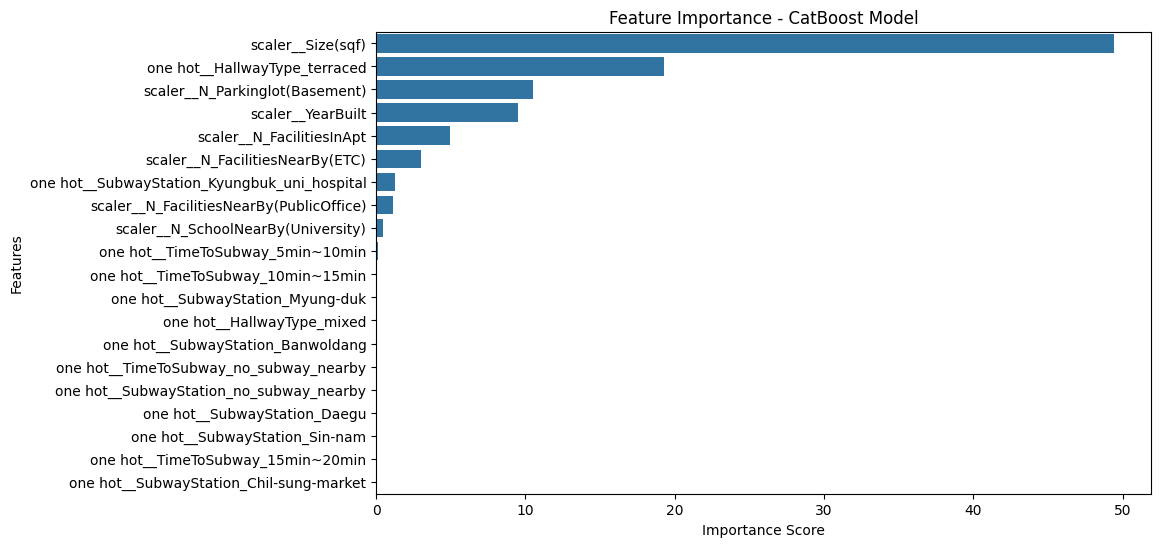

In [61]:
# Plot the feature importances using seaborn barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)

# Set the title and labels
plt.title('Feature Importance - CatBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')

# Display the plot
plt.show()


In [62]:
pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 30.8 MB/s eta 0:00:00


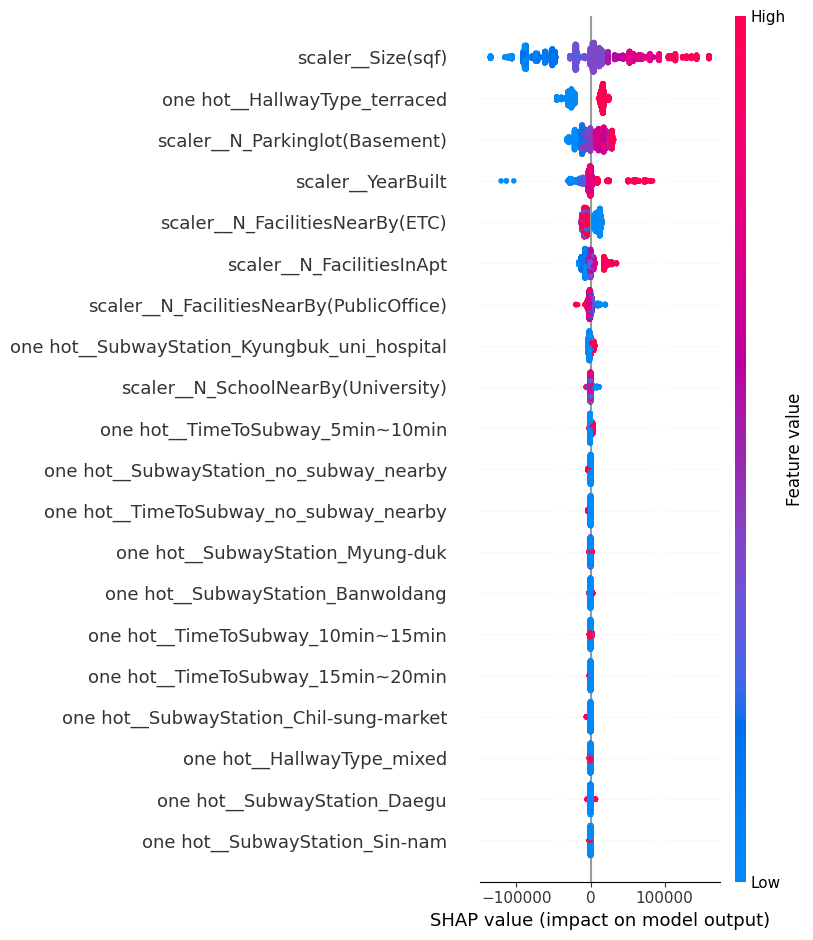

In [63]:
import shap

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(best_catboost_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train)

# Plot SHAP summary
shap.summary_plot(shap_values, X_train)


It has been proven that Size and HallwayType (terraced) are the two most important features in predicting SalePrice, which aligns with the analysis in the EDA. Other significant variables include the number of parking spaces (basement), YearBuilt, the number of facilities in the apartment, Electronic Toll Collection (ETC), proximity to the Kyungbuk University Hospital subway station, the number of public offices, and nearby universities.

These factors significantly influence apartment pricing in Daegu.

### Potential Overfitting Checking

0:	learn: 99500.7474556	test: 100639.6748743	best: 100639.6748743 (0)	total: 1.22ms	remaining: 364ms
100:	learn: 42888.3826568	test: 41738.1980666	best: 41738.1980666 (100)	total: 207ms	remaining: 407ms
200:	learn: 42239.8817789	test: 41362.7751966	best: 41357.5735763 (194)	total: 494ms	remaining: 244ms
299:	learn: 42098.9031518	test: 41320.4749544	best: 41320.4749544 (299)	total: 744ms	remaining: 0us

bestTest = 41320.47495
bestIteration = 299



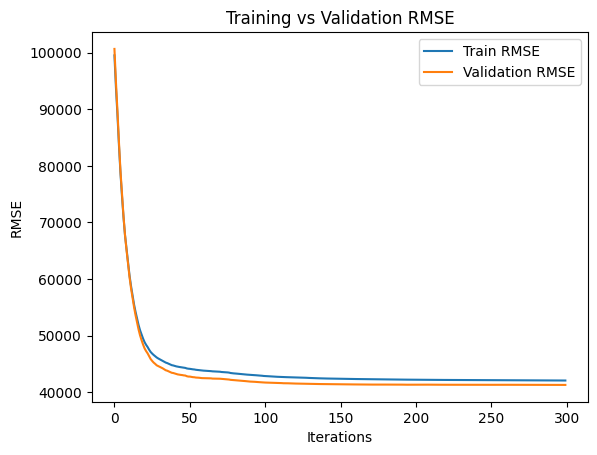

In [64]:
# Fit the model with logging of evaluation metrics
model = CatBoostRegressor(depth=4, iterations=300, l2_leaf_reg=7, learning_rate=0.1, verbose=0)

# Fit the model and store the evaluation history
eval_history = model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=False, verbose=100)

# Step 3: Extract the loss history
train_errors = model.get_evals_result()['learn']['RMSE']  # Training error
validation_errors = model.get_evals_result()['validation']['RMSE']  # Validation error

# Step 4: Plot the learning curve
plt.plot(train_errors, label='Train RMSE')
plt.plot(validation_errors, label='Validation RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend()
plt.title('Training vs Validation RMSE')
plt.show()


Based on the graph above, the model demonstrates neither overfitting nor underfitting, as indicated by the relatively close range of train RMSE and validation RMSE across iterations. Therefore, the CatBoost model is ready for use.

### Limitation

In [70]:
df.describe()

,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
count,4123.000000,4123.000000,4123.000000,4123.000000,4123.000000,4123.000000,4123.000000,4123.000000
mean,1.930876,4.135338,2.746301,568.979141,2002.999757,5.817851,954.630851,221767.926995
std,2.198832,1.802640,1.496610,410.372742,8.905768,2.340507,383.805648,106739.839945
min,0.000000,0.000000,0.000000,0.000000,1978.000000,1.000000,135.000000,32743.000000
25%,0.000000,3.000000,2.000000,184.000000,1993.000000,4.000000,644.000000,144752.000000
50%,1.000000,5.000000,2.000000,536.000000,2006.000000,5.000000,910.000000,209734.000000
75%,5.000000,5.000000,4.000000,798.000000,2008.000000,7.000000,1149.000000,291150.000000
max,5.000000,7.000000,5.000000,1321.000000,2015.000000,10.000000,2337.000000,585840.000000


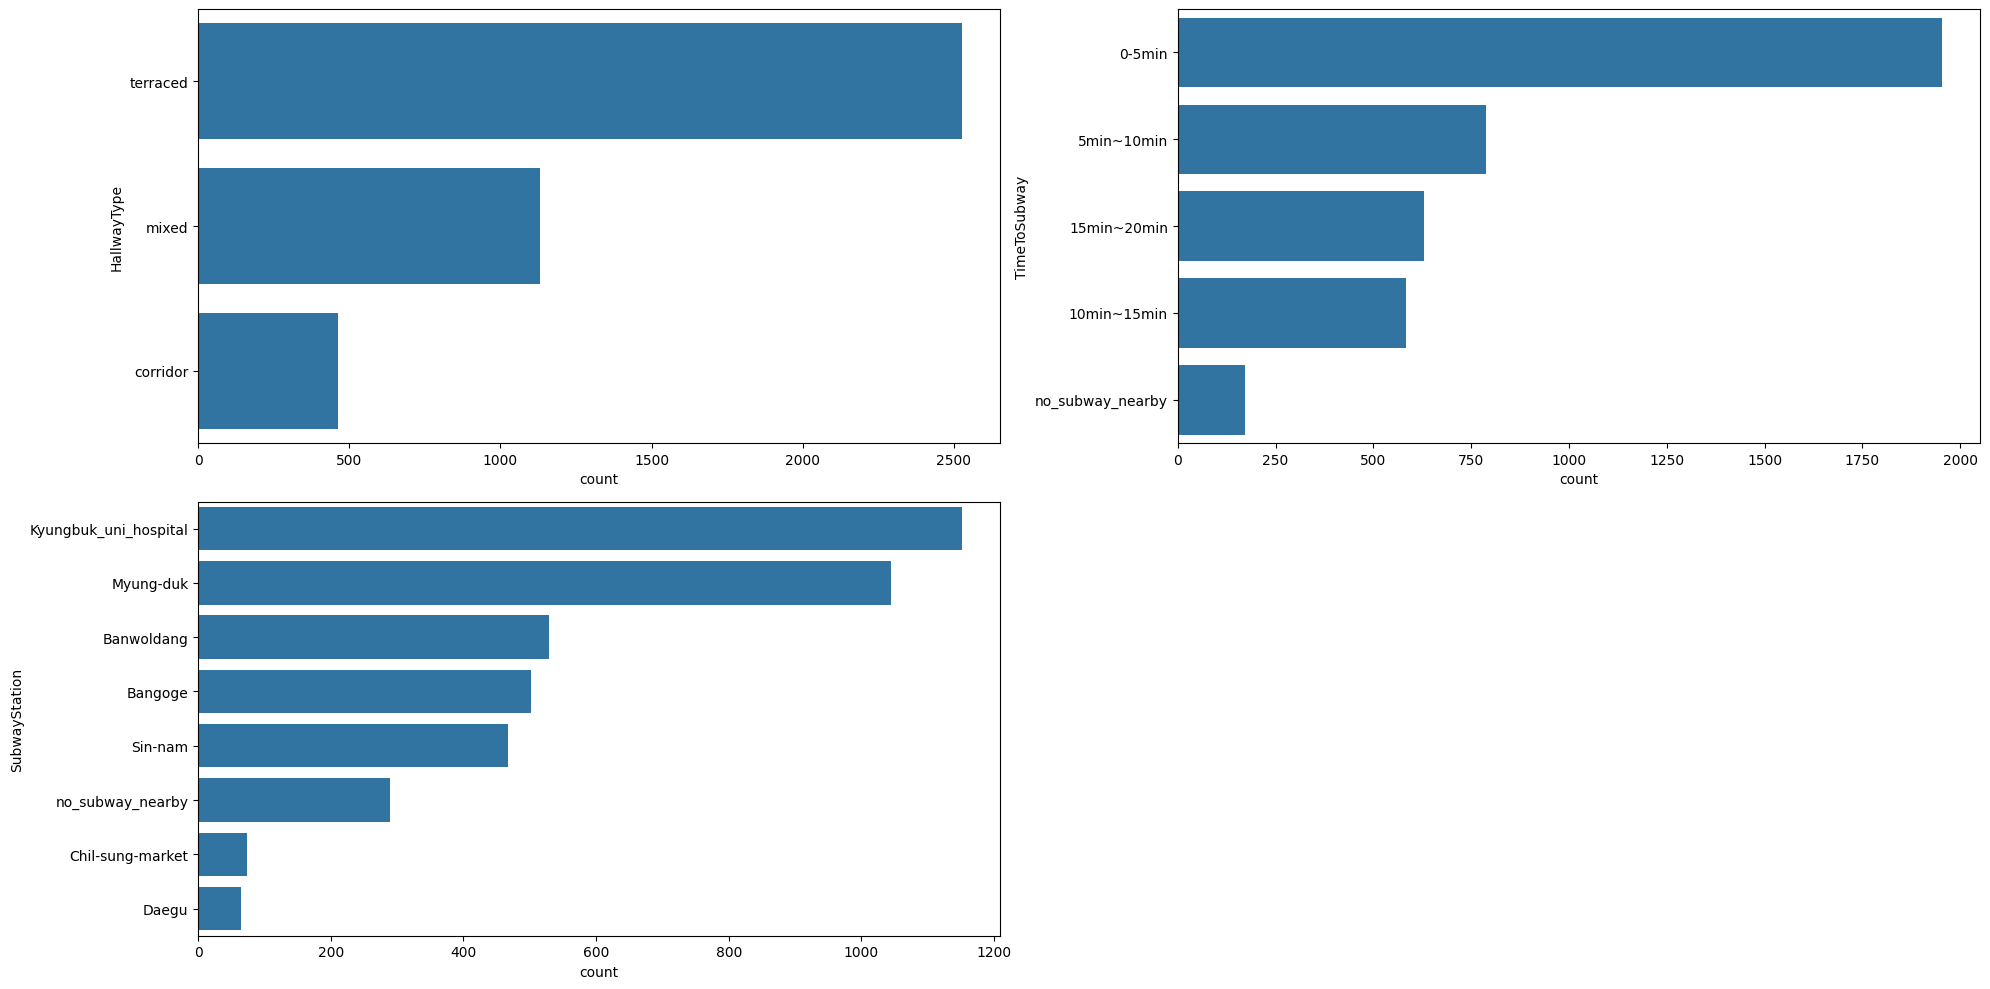

In [71]:
plt.figure(figsize = (20,10))

position = 1 # Initiating position starting from 1
for each_column in categorical.columns:
    plt.subplot(2,2,position)
    sns.barplot(df[each_column].value_counts(), orient = 'h')
    position = position + 1
    plt.tight_layout()

This model has limitations, as it was trained only on data within a specific range. Therefore, if an apartment possesses qualities outside this training range, the predicted SalePrice may not be accurately estimated.

| Variable | Range |
|---- | ---- |
| HallwayType | Terraced, Mixed, and Corridor|
| TimeToSubway | 0-5 min; 5-10 min; 10-15 min; 15-20 min; and no_subway_nearby|
| SubwayStation | The name of the nearest subway station, there are 7 nearest subway and 1 no subway nearby|
| N_FacilitiesNearBy(ETC) | 0, 1, 2, and 5 |
| N_FacilitiesNearBy(PublicOffice) | 0 - 7 |
| N_SchoolNearBy(University) | 0 - 5 |
| N_Parkinglot(Basement) | 0, 18, 56, 76, 79, 108, 181, 184, 203, 218, 400, 475, 524, 536, 605, 798, 930, 1174, 1270, 1321|
| YearBuilt | 1978, 1980, 1985, 1986, 1992, 1993, 1997, 2003, 2005, 2006, 2007, 2008, 2009, 2013, 2014, 2015|
| N_FacilitiesInApt | 1 - 10|
| Size(sqf)| 135 - 2,337|
| SalePrice| 32,743 - 585,840|

RMSE: 41320.4750


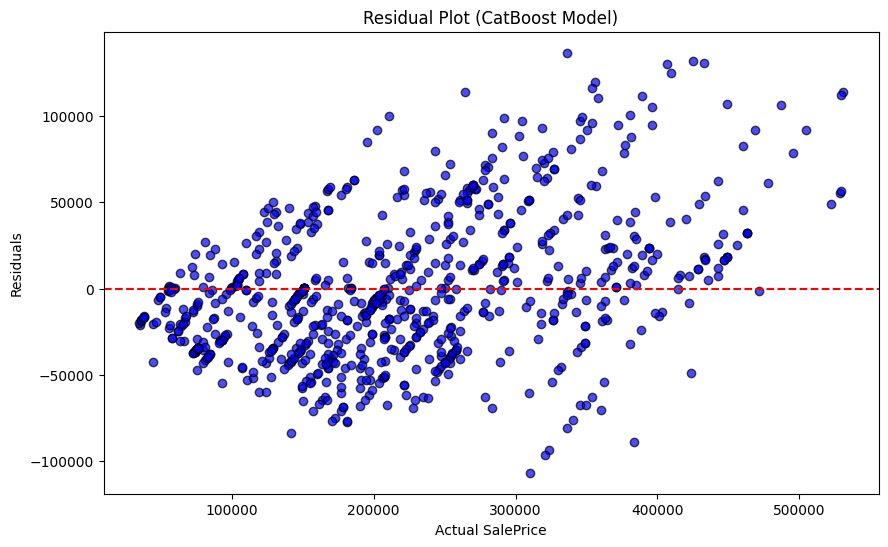

In [66]:
# Step 1: Make predictions using trained CatBoost model
y_pred = model.predict(X_test)

# Step 2: Calculate residuals
residuals = y_test - y_pred

# Step 3: Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print RMSE value
print(f"RMSE: {rmse:.4f}")

# Step 4: Create a DataFrame to see the actual SalePrice, predicted SalePrice, and residuals
residuals_df = pd.DataFrame({
    'Actual SalePrice': y_test,
    'Predicted SalePrice': y_pred,
    'Residuals': residuals
})

# Step 5: Plot the residuals
plt.figure(figsize=(10,6))
plt.scatter(y_test, residuals, color='blue', edgecolors='black', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot (CatBoost Model)')
plt.xlabel('Actual SalePrice')
plt.ylabel('Residuals')
plt.show()


In [67]:
# Step 1: Make predictions using trained CatBoost model
y_pred = model.predict(X_test)

# Step 2: Calculate residuals
residuals = y_test - y_pred

# Step 3: Create a DataFrame to analyze residuals
residuals_df = pd.DataFrame({
    'SalePrice': y_test,  # Include SalePrice for binning
    'Residuals': residuals
})

# Step 4: Define bins for SalePrice
bins = [0, 50000, 100000, 200000, 300000, 400000, 500000, 600000]
labels = ['0-50k', '50k-100k', '100k-200k', '200k-300k', '300k-400k', '400k-500k', '500k-600k']  # Bin labels

# Step 5: Create a new column for the bins
residuals_df['SalePrice_Bin'] = pd.cut(residuals_df['SalePrice'], bins=bins, labels=labels, right=False)

# Step 6: Calculate RMSE for each bin
rmse_per_bin = residuals_df.groupby('SalePrice_Bin')['Residuals'].apply(lambda x: np.sqrt(np.mean(x**2)))

# Step 7: Calculate the mean SalePrice for percentage calculation
mean_sale_price = residuals_df['SalePrice'].mean()

# Step 8: Convert RMSE to percentage of the mean SalePrice
rmse_percentage = (rmse_per_bin / mean_sale_price) * 100

# Step 9: Create a DataFrame for RMSE percentage statistics
rmse_stats_df = pd.DataFrame(rmse_percentage).reset_index()
rmse_stats_df.columns = ['SalePrice_Bin', 'RMSE_Percentage']

# Step 10: Print the RMSE percentage statistics DataFrame
rmse_stats_df


<ipython-input-67-ab66502f63ca>:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rmse_per_bin = residuals_df.groupby('SalePrice_Bin')['Residuals'].apply(lambda x: np.sqrt(np.mean(x**2)))


,SalePrice_Bin,RMSE_Percentage
0,0-50k,8.843444
1,50k-100k,12.791726
2,100k-200k,16.568269
3,200k-300k,17.949587
4,300k-400k,25.363972
5,400k-500k,25.733578
6,500k-600k,38.769828


Based on RMSE, this model has limitations as well. The table above indicates that the model performs best at predicting lower-priced apartments. In contrast, its performance diminishes when predicting higher-priced apartments, as evidenced by the increasing RMSE percentage with higher SalePrices.

### Estimated Benefit

In [69]:
import numpy as np

# Given RMSE values
rule_based_rmse = 79598.1420
catboost_rmse = 41320.4750

# Average sale price for the apartment
average_sale_price = 209734  # median

# Calculate the percentage error reduction in RMSE
rmse_improvement = (rule_based_rmse - catboost_rmse) / rule_based_rmse * 100

# Estimate potential increased revenue based on the number of apartments sold
number_of_apartments_sold = 4123  # total row of the data

# Potential financial benefit from RMSE improvement
financial_benefit_rmse = (rule_based_rmse - catboost_rmse) * number_of_apartments_sold

# Calculate total sales before using CatBoost
total_sales = average_sale_price * number_of_apartments_sold

# Calculate percentage of the benefit from total sales
percentage_benefit = (financial_benefit_rmse / total_sales) * 100

# Display results
print(f"RMSE Improvement: {rmse_improvement:.2f}%")
print(f"Potential Financial Benefit from RMSE: {financial_benefit_rmse:,.2f} Won")
print(f"Percentage of Financial Benefit from Total Sales: {percentage_benefit:.2f}%")


RMSE Improvement: 48.09%
Potential Financial Benefit from RMSE: 157,818,821.04 Won
Percentage of Financial Benefit from Total Sales: 18.25%


Based on the calculations above, if management decides to use my model to predict apartment pricing in Daegu, they could potentially achieve an 18.25% increase in sales, equivalent to more than 150 million won.

# Conclusion and Recommendation

## Conclusion

Based on above analysis, the conclusion are:

1. The best model for predicting apartment pricing in Daegu is the CatBoost model.
2. The model was optimized using GridSearchCV, resulting in the following best parameter performance: depth: 4, iterations: 300, l2_leaf_reg: 7, learning_rate: 0.1.
3. The model's accuracy is R²: 0.8530 and RMSE: 41,320.
4. The potential benefit of using the CatBoost model is an 18.25% increase in sales, equivalent to over 150 million won.

## Recommendation for Model

The model may not be a good fit for predicting luxury apartments with higher-end pricing, as these apartments could be influenced by additional factors. Therefore, management should investigate other variables that may impact pricing and consider weighing these factors in their predictions. Additionally, the model requires more data to improve its accuracy in predicting higher-end apartments.

## Recommendation for Business

Management could potentially benefit from an 18.25% increase in sales by using the model. The analysis indicates that size is the most important feature in predicting apartment pricing; the **larger the size** of the apartment, the higher its predicted price. Hallway type is also significant, with **terraced types** expected to command higher prices than other types. This relationship is further explored in the EDA section.

Consequently, management should focus on **expanding the size** of apartments and **incorporating terraced hallway** types to boost sales. Additionally, enhancing the **number of basement parking spaces** and available facilities would be beneficial. When constructing apartments, management should consider proximity to the **Kyungbuk University Hospital** subway station, public offices, and nearby universities, as these factors also influence apartment pricing.